In [14]:
#<GRADED>
import numpy as np
from numpy.matlib import repmat
import sys
import time
from cvxpy import *
from l2distance import l2distance
#</GRADED>
import matplotlib
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from visclassifier import visclassifier

%matplotlib inline

<!--announcements-->
<blockquote>
    <center>
    <img src="yinyang.png" width="400px" /></a>
    </center>
      <p><cite><center>"Just as we have two eyes and two feet,<br>
      duality is part of life."<br>
<b>--Carlos Santana</b><br>
      </center></cite></p>
</blockquote>


<h3>Introduction</h3>
In this project, you will implement a linear support vector machine and one operating in kernel space. For this you will need to formulate the primal and dual optimization problems as quadratic programs. You will be using <code>cvxpy</code>. Before we get started please read through the <a href="http://www.cvxpy.org/en/latest/tutorial/index.html">tutorial</a> of cvxpy and its quadratic programming solver.

<h4> Linear classification</h4>

<p> The first assignment is to implement a linear support vector machine. Before we get started we can generate some data to see if everything is working:  
</p>

In [15]:
def genrandomdata(n=100,b=0.):
    # generate random data and linearly separagle labels
    xTr = np.random.randn(n, 2)
    # defining random hyperplane
    w0 = np.random.rand(2, 1)
    # assigning labels +1, -1 labels depending on what side of the plane they lie on
    yTr = np.sign(np.dot(xTr, w0)+b).flatten()
    return xTr, yTr

<p>Remember the SVM primal formulation
$$\begin{aligned}
             &\min_{\mathbf{w},b,\xi} \|\mathbf{w}\|^2_2+C \sum_{i=1}^n \xi_i\\
       & \text{such that }  \ \forall i:\\
             & y_i(\mathbf{w}^\top \mathbf{x}_i+b)\geq 1-\xi_i\\
             & \xi_i\geq 0.\\
\end{aligned}
$$
You will need to implement  the function <code>SVMprimal</code>, which  takes is important training data <code>xTr</code> ($n\times d$) and labels <code>yTr</code> ($n\times 1$) with <code>yTr[i]</code>$\in \{-1,1\}$. Currently, the code below is a placeholder example of a <code>cvxpy</code> optimization problem. You need to update the objective, the constraints and introduce new variables to output the correct hyperplane and bias. </p>

In [16]:
#<GRADED>
def primalSVM(xTr, yTr, C=1):
    """
    function (classifier,w,b) = primalSVM(xTr,yTr;C=1)
    constructs the SVM primal formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        xTr   | training data (nxd)
        yTr   | training labels (nx1)
        C     | the SVM regularization parameter
    
    Output:
        fun   | usage: predictions=fun(xTe);
        wout  | the weight vector calculated by the solver
        bout  | the bias term calculated by the solver
    """
    N, d = xTr.shape
    y = yTr.flatten()
    """
    # dummy code: example of establishing objective and constraints, and let the solver solve it.
    w = Variable(d)
    b = Variable(1)
    objective = sum_squares(w)
    constraints = [w >= 0]
    prob = Problem(Minimize(objective), constraints)
    prob.solve()
    wout = w.value
    bout = b.value
    # End of dummy code
    """
    # TODO 1
    w = Variable(d)
    b = Variable(1)
    Xi = Variable(N)
    objective = sum_squares(w) + C * sum_entries(Xi)
    constraints = [Xi >= 0,mul_elemwise(y, xTr*w + b) >= 1 - Xi]
    prob = Problem(Minimize(objective), constraints)
    prob.solve()
    wout = w.value
    bout = b.value
    
    
    fun = lambda x: x.dot(wout) + bout
    return fun, wout, bout
#</GRADED>

We can test your SVM primal solver with the following randomly generated data set. We label it in a way that it is guaranteed to be linearly separable. If your code works correctly the hyper-plane should separate all the $x$'s into the red half and all the $o$'s into the blue half. With sufficiently large values of $C$ (e.g. $C>10$) you should obtain $0\%$ training error. 

In [17]:
def arrayify(x):
    """flattens and converts to numpy"""
    return np.array(x).flatten()

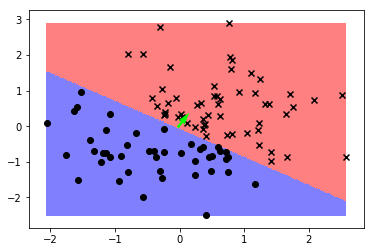

Training error: 0.0%


In [18]:
xTr,yTr=genrandomdata()
fun,w,b=primalSVM(xTr,yTr,C=10)
visclassifier(fun,xTr,yTr,w=w,b=b)

err=np.mean(arrayify(np.sign(fun(xTr)))!=yTr)
print("Training error: %2.1f%%" % (err*100))

<h4>Spiral data set</h4>

<p>The linear classifier works great in simple linear cases. But what if the data is more complicated? We provide you with a "spiral" data set. You can load it and visualize it with the following two code snippets:
<pre>

In [19]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

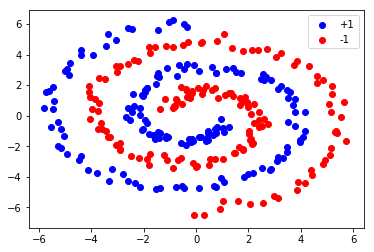

In [20]:
xTr,yTr,xTe,yTe=spiraldata()
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

<p>If you apply your previously functioning linear classifier on this data set you will see that you get terrible results. Your training error will increase drastically. </p>

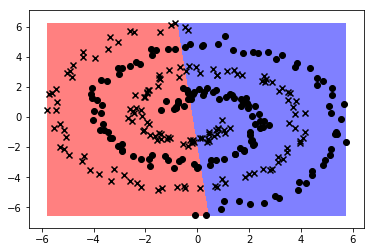

Training error: 41.0%


In [21]:
fun,w,b=primalSVM(xTr,yTr,C=10)
visclassifier(fun,xTr,yTr,w=[],b=0)
err=np.mean(arrayify(np.sign(fun(xTr)))!=yTr)
print("Training error: %2.1f%%" % (err*100))

<h3>Implementing a kernelized SVM</h3>

<p> For something as complex as the spiral data set, you need a more complex classifier. 
First implement the kernel function
<pre>	computeK(kerneltype,X,Z,kpar)</pre>
It takes as input a kernel type (kerneltype) and two data sets $\mathbf{X}$ in $\mathcal{R}^{n\times d}$ and $\mathbf{Z}$ in $\mathcal{R}^{m\times d}$ and outputs a kernel matrix $\mathbf{K}\in{\mathcal{R}^{n\times m}}$. The last input, <code>kpar</code> specifies the kernel parameter (e.g. the inverse kernel width $\gamma$ in the RBF case or the degree $p$ in the polynomial case.)
	<ol>
	<li>For the linear kernel (<code>ktype='linear'</code>) svm, use $k(\mathbf{x},\mathbf{z})=x^Tz$ </li> 
	<li>For the radial basis function kernel (<code>ktype='rbf'</code>) svm use $k(\mathbf{x},\mathbf{z})=\exp(-\gamma ||x-z||^2)$ (gamma is a hyperparameter, passed a the value of kpar)</li>
	<li>For the polynomial kernel (<code>ktype='poly'</code>) use  $k(\mathbf{x},\mathbf{z})=(x^Tz + 1)^p$ (p is the degree of the polymial, passed as the value of kpar)</li>
</ol>

<p>You can use the function <b><code>l2distance</code></b> as a helperfunction.</p>





In [22]:
#<GRADED>
def computeK(kerneltype, X, Z, kpar=0):
    """
    function K = computeK(kernel_type, X, Z)
    computes a matrix K such that Kij=g(x,z);
    for three different function linear, rbf or polynomial.
    
    Input:
    kerneltype: either 'linear','polynomial','rbf'
    X: n input vectors of dimension d (dxn);
    Z: m input vectors of dimension d (dxn);
    kpar: kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    OUTPUT:
    K : nxm kernel matrix
    """
    
    assert kerneltype in ["linear","polynomial","poly","rbf"], "Kernel type %s not known." % kerneltype
    assert X.shape[1] == Z.shape[1], "Input dimensions do not match"
    
    # TODO 2
    n,_ = X.shape
    m,_ = Z.shape
    K = np.zeros((n,m))
    if kerneltype == "linear":
        K = X.dot(Z.T)
    elif kerneltype == "polynomial" or kerneltype == "poly":
        K = (X.dot(Z.T) + 1) ** kpar
    else:
        '''
        X2 = np.tile(np.diag(X.dot(X.T)),(m,1))
        Z2 = np.tile(np.diag(Z.dot(Z.T)),(n,1))  
        K = np.exp(-1 * kpar * (X2 + Z2 - 2 * X.dot(Z.T)))
       '''
        K = np.exp(-1 * kpar * (l2distance(X,Z)**2))
    return K
#</GRADED>

<p>The following code snippet plots an image of the kernel matrix for the data points in the spiral set. Use it to test your <b><code>computeK</code></b> function:</p>

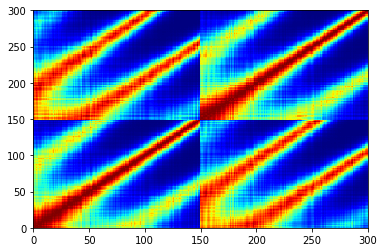

In [23]:
xTr,yTr,xTe,yTe=spiraldata()
K=computeK("rbf",xTr,xTr,kpar=0.05)
# plot an image of the kernel matrix
plt.pcolormesh(K, cmap='jet')
plt.show()

Remember that the SVM optimization has the following dual formulation:
$$
\begin{aligned}
             &\min_{\alpha_1,\cdots,\alpha_n}\frac{1}{2} \sum_{i,j}\alpha_i \alpha_j y_i y_j \mathbf{K}_{ij} - \sum_{i=1}^{n}\alpha_i  \\
       \text{s.t.}  &\quad 0 \leq \alpha_i \leq C\\
             &\quad \sum_{i=1}^{n} \alpha_i y_i = 0.
\end{aligned}
$$
This is equivalent to solving for the SVM primal
$$ L(\mathbf{w},b) = C\sum_{i=1}^n \max(1-y_i(\mathbf{w}^\top\phi(\mathbf{x}_i)+b),0) + ||w||_2^2$$
where $\mathbf{w}=\sum_{i=1}^n y_i \alpha_i \phi(\mathbf{x}_i)$ and $\mathbf{K}_{ij}=k(\mathbf{x}_i,\mathbf{x}_j)=\phi(\mathbf{x}_i)^\top\phi(\mathbf{x}_j)$, for some mapping $\phi(\cdot)$.  Please note that here all $\alpha_i\geq 0$, which is possible because we multiply by $y_i$ in the definition of $\mathbf{w}$. One advantage of keeping all $\alpha_i$ non-negative is that we can easily identify non-support vectors as vectors with $\alpha_i=0$. 

<p>Implement the function <code>dualqp</code>, which takes as input a kernel matrix $K$, a vector of labels $yTr$ in $\mathcal{R}^{n}$, and a regularization constant $C\geq 0$. This function should solve the quadratic optimization problem and output the optimal vector $\mathbf{\alpha}\in{\mathcal{R}^n}$.</p>



In [24]:
#<GRADED>
def dualqp(K,yTr,C):
    """
    function alpha = dualqp(K,yTr,C)
    constructs the SVM dual formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        K     | the (nxn) kernel matrix
        yTr   | training labels (nx1)
        C     | the SVM regularization parameter
    
    Output:
        alpha | the calculated solution vector (nx1)
    """
    y = yTr.flatten()
    N, _ = K.shape
    alpha = Variable(N)
    
    # TODO 3:
    Y = y.reshape((-1,1))
    
    kernel =  np.multiply(Y * Y.T, K)
    objective = 0.5 * quad_form(alpha, kernel) - sum_entries(alpha)
    
   # alphanew =  mul_elemwise(y, alpha)
   # objective = 0.5 * quad_form(alphanew, K) - sum_entries(alpha)
    
    constraints = [0 <= alpha ,alpha <= C, sum_entries(mul_elemwise(y, alpha)) == 0]
    prob = Problem(Minimize(objective), constraints)
    prob.solve()

    
    return np.array(alpha.value).flatten()
#</GRADED>

The following code shows a usecase of how <code>dualqp</code> could be used in practice. 

In [25]:
C = 10
lmbda = 0.25
ktype = "rbf"
xTr,yTr,xTe,yTe=spiraldata()
# compute kernel (make sure it is PSD)

K = computeK(ktype,xTr,xTr)
eps = 1e-10
# make sure it is symmetric and positive semi-definite
K = (K + K.T) / 2 + eps * np.eye(K.shape[0])

alpha=dualqp(K,yTr,C)
# print(alpha)

<p> Now that you can solve the dual correctly, you should have the values for $\alpha_i$. But you are not done yet. You still need to be able to classify new test points. Remember from class that $h(\mathbf{x})=\sum_{i=1}^n \alpha_i y_i k(\mathbf{x}_i,\mathbf{x})+b$. You need to obtain $b$. It is easy to show (and omitted here) that if $C>\alpha_i>0$ (with strict $>$), then we must have that $y_i(\mathbf{w}^\top \phi(\mathbf{x}_i)+b)=1$. Rephrase this equality in terms of $\alpha_i$ and solve for $b$. Implement

<p> b=recoverBias(K,yTr,alphas,C); </p>

<p> where <code>b</code> is the hyperplane bias.
(Hint: This is most stable if you pick an $\alpha_i$ that is furthest from $C$ and $0$. )</p>

<p>Please note that this use of the word bias has absolutely nothing to do with the word bias in the bias variance trade-off. This unfortunate term collision comes from the fact that we are borrowing concepts from geometry and statistics.</p>

In [26]:
#<GRADED>
def recoverBias(K,yTr,alpha,C):
    """
    function bias=recoverBias(K,yTr,alpha,C);
    Solves for the hyperplane bias term, which is uniquely specified by the 
    support vectors with alpha values 0<alpha<C
    
    INPUT:
    K : nxn kernel matrix
    yTr : 1xn input labels
    alpha  : nx1 vector of alpha values
    C : regularization constant
    
    Output:
    bias : the scalar hyperplane bias of the kernel SVM specified by alphas
    """
    
    # TODO 4
    nonsv = np.argwhere(alpha <= 0)
    dist = np.minimum(alpha, C - alpha)
    dist[nonsv] = 0
    index = np.argmax(dist)

    bias = yTr[index] - np.sum(yTr * alpha* K[:,index])

    return bias
#</GRADED>

<p> Test your <b><code>recoverBias</code></b> function with the following code, which uses the dual solver on a linearly separable dataset:</p>

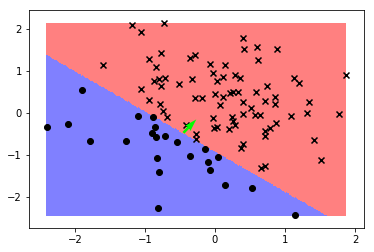

In [27]:
xTr,yTr=genrandomdata(b=0.5)
C=10
K=computeK("linear",xTr,xTr)
eps=1e-10
K = (K + K.T) / 2 + eps * np.eye(K.shape[0])
alpha = dualqp(K,yTr,C)
ba=recoverBias(K,yTr,alpha,C)
wa = (alpha * yTr).dot(xTr)
fun = lambda x: x.dot(wa) + ba
visclassifier(fun, xTr, yTr, w=wa, b=ba)

<p>
    Implement the function 
    <pre>
    svmclassify=dualSVM(xTr,yTr,C,ktype,kpar);
    </pre>
    It should use your functions <code><b>computeK</b></code> and <code><b>generateQP</b></code> to solve the SVM dual problem of an SVM specified by a training data set (<code><b>xTr,yTr</b></code>), a regularization parameter (<code>C</code>), a kernel type (<code>ktype</code>) and kernel parameter (<code>lmbda</code>, to be used as kpar in Kernel construction). Then, find the support vectors and recover the bias to return <b><code>svmclassify</code></b>, a function that uses your SVM to classify a set of test points <code>xTe</code>.

    
</p>


In [28]:
#<GRADED>
def dualSVM(xTr,yTr,C,ktype,lmbda):
    """
    function classifier = dualSVM(xTr,yTr,C,ktype,lmbda);
    Constructs the SVM dual formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        xTr   | training data (nxd)
        yTr   | training labels (nx1)
        C     | the SVM regularization parameter
        ktype | the type of kernelization: 'rbf','polynomial','linear'
        lmbda | the kernel parameter - degree for poly, inverse width for rbf
    
    Output:
        svmclassify | usage: predictions=svmclassify(xTe);
    """
    #svmclassify = lambda x: x #Dummy code
    
    # TODO 5

    K = computeK(ktype,xTr,xTr,lmbda)

    eps=1e-10
    K = (K + K.T) / 2 + eps * np.eye(K.shape[0])
    alpha = dualqp(K,yTr,C)
    ba = recoverBias(K,yTr,alpha,C)
    
    alphay = alpha * yTr
    wa = alphay.dot(xTr)
    
    svmclassify = lambda x: x.dot(wa) + ba if ktype == "linear" else (alphay.dot(np.exp(-lmbda * (l2distance(xTr,x)**2))) + ba if ktype == "rbf" 
          else alphay * ((xTr.dot(x.T) + 1) ** lmbda))
    
    return svmclassify
#</GRADED>

<p>Now we try the SVM with RBF kernel on the spiral data. If you implemented it correctly, train and test error should be close to zero.</p>

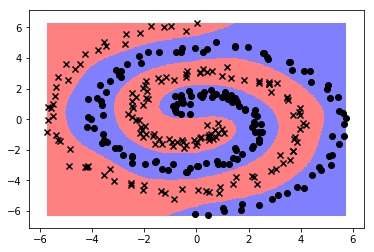

Training error: 0.0000
Testing error: 0.0033


In [29]:
xTr,yTr,xTe,yTe=spiraldata()
C=10.0
sigma=0.25
ktype="rbf"
svmclassify=dualSVM(xTr,yTr,C,ktype,sigma)

visclassifier(svmclassify,xTr,yTr)

# compute training and testing error
predsTr=svmclassify(xTr)
trainingerr=np.mean(np.sign(predsTr)!=yTr)
print("Training error: %2.4f" % trainingerr)

predsTe=svmclassify(xTe)
testingerr=np.mean(np.sign(predsTe)!=yTe)
print("Testing error: %2.4f" % testingerr)

SVMs are pretty sensitive to hyper-parameters. We can visualize the results of a hyper-parameter grid search as a heat-map, where we sweep across different values of C and kpar and output the result on a validation dataset. Now we ask you to implement a cross-validation function.

In [30]:
#<GRADED>
def cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList):
    """
    function bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList);
    Use the parameter search to find the optimal parameter,
    Individual models are trained on (xTr,yTr) while validated on (xValid,yValid)
    
    Input:
        xTr      | training data (nxd)
        yTr      | training labels (nx1)
        xValid   | training data (mxd)
        yValid   | training labels (mx1)
        ktype    | the type of kernelization: 'rbf','polynomial','linear'
        CList    | The list of values to try for the SVM regularization parameter C (ax1)
        lmbdaList| The list of values to try for the kernel parameter lmbda- degree for poly, inverse width for rbf (bx1)
    
    Output:
        bestC      | the best C parameter
        bestLmbda  | the best Lmbda parameter
        ErrorMatrix| the test error rate for each given C and Lmbda when trained on (xTr,yTr) and tested on (xValid,yValid),(axb)
    """
    # gridsearch for best parameters
    ErrorMatrix=np.zeros((len(CList),len(lmbdaList)))
    bestC,bestLmbda = 0.,0.
    
    # TODO 6
    for row, C in enumerate(CList):
        for col, lmbda in enumerate(lmbdaList):
            svmclassify=dualSVM(xTr,yTr,C,ktype,lmbda)
            predsValid=svmclassify(xValid)
            ErrorMatrix[row,col]=np.mean(np.sign(predsValid)!=yValid)
            
    index = np.argmax(ErrorMatrix.flatten())
    bestC = CList[index//len(lmbdaList)]
    bestLmbda = lmbdaList[index%len(lmbdaList)]
    return bestC,bestLmbda,ErrorMatrix
#</GRADED>

[ 0.5  1.   2.   4.   8.  16.  32. ]
[0.1 0.2 0.3 0.4 0.5]
0.5 0.1


Text(0.5,1,'Validation error')

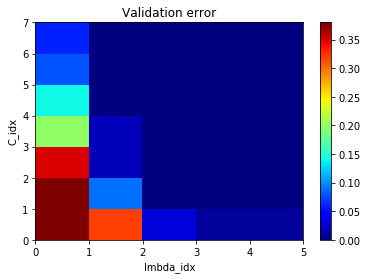

In [38]:
xTr,yTr,xValid,yValid=spiraldata(100)
CList=(2.0**np.linspace(-1,5,7))
lmbdaList=(np.linspace(0.1,0.5,5))

bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,'rbf',CList,lmbdaList)

print(CList)
print(lmbdaList)
print(bestC, bestLmbda)

plt.pcolormesh(ErrorMatrix, cmap='jet')
plt.colorbar()
plt.xlabel("lmbda_idx")
plt.ylabel("C_idx")
plt.title("Validation error")

If you implemented everything correctly, the result should look similar to this image:
<center>
 <img src="crossval.png" width="300px" />
</center>

Competition: we ask you to implement function autosvm, which given xTr and yTr, splits them into training data and validation data, and then uses a hyperparameter search to find the optimal hyper parameters. 

Function autosvm should return a function which will act as a classifier on xTe.

You have a 5 minute time limit on multiple datasets, each dataset having different optimal hyperparameters, so you should strive for a good method of finding hyperparameters (within the time limit) instead of just trying to find a static set of good hyperparameters. 

You will get extra credit for the competition if you can beat the base benchmark of 34% error rate.

SyntaxError: invalid syntax (<ipython-input-177-8967b7ea79a7>, line 599)

In [234]:
#<GRADED>
def autosvm(xTr,yTr):
    
    import datetime
    starttime = datetime.datetime.now()
    """
    svmclassify = autosvm(xTr,yTr), where yTe = svmclassify(xTe)
    """
    
    assert xTr.shape[0] == yTr.shape[0]
    
    size = xTr.shape[0]
    
    valsize = int(size/5)
    
    validx = np.random.choice(size,valsize, replace = False) #index of validation tests

    xVal= xTr[validx,:]
    yVal = yTr[validx]
    
    xTrTemp = np.delete(xTr,validx,0)
    yTrTemp = np.delete(yTr,validx,0)
    
    
    '''
    CList=(2.0**np.linspace(-2,5,2))
    lmbdaList=(np.linspace(0.1,0.5,2))
    

    print(xTr.shape)

    #bestC,bestLmbda,ErrorMatrix = cross_validation(xTrTemp,yTrTemp,xVal,yVal,'rbf',CList,lmbdaList)
    np.set_printoptions(threshold=np.nan)
    #print(np.array2string(xTr, separator=', '))
    #print(np.array2string(yTr, separator=', '))
    
    def p(x):
        print((np.array2string(x, separator=', ')))
    
    return p
    
    

    '''
    ytick = np.linspace(-11.25,6,10)
    xtick = np.linspace(0.1,0.6,5)
    
    CList=(2.0**ytick)
    lmbdaList=(xtick)

    bestC,bestLmbda, ErrorMatrix = cross_validation(xTrTemp,yTrTemp,xVal,yVal,'rbf',CList,lmbdaList)
    
    print(bestLmbda,np.log2(bestC))
#     plt.imshow(ErrorMatrix, cmap='jet', extent = [2*xtick[0]-xtick[1]+(xtick[1]-xtick[0])/2,xtick[-1]+(xtick[1]-xtick[0])/2,ytick[-1]+(ytick[1]-ytick[0])/2,2*ytick[0]-ytick[1]+(ytick[1]-ytick[0])/2],aspect='auto')
#     plt.colorbar()
#     plt.xlabel("lmbda_idx")
#     plt.ylabel("C_idx")
#     plt.title("Validation error")
#     plt.xticks(xtick)
#     plt.yticks(ytick)
#     plt.show()   
    
    
    xtickmin = max(0.225-0.125,bestLmbda-0.125)
    
    ytick = np.linspace(np.log2(bestC)-2.25,np.log2(bestC)+2.25,5)
    xtick = np.linspace(xtickmin,0.25+xtickmin,5)
    
    CList=(2.0**ytick)
    lmbdaList=(xtick)

    bestC,bestLmbda, ErrorMatrix = cross_validation(xTrTemp,yTrTemp,xVal,yVal,'rbf',CList,lmbdaList)
    
    print(bestLmbda,np.log2(bestC))
#     plt.imshow(ErrorMatrix, cmap='jet', extent = [2*xtick[0]-xtick[1]+(xtick[1]-xtick[0])/2,xtick[-1]+(xtick[1]-xtick[0])/2,ytick[-1]+(ytick[1]-ytick[0])/2,2*ytick[0]-ytick[1]+(ytick[1]-ytick[0])/2],aspect='auto')
#     plt.colorbar()
#     plt.xlabel("lmbda_idx")
#     plt.ylabel("C_idx")
#     plt.title("Validation error")
#     plt.xticks(xtick)
#     plt.yticks(ytick)
#     plt.show()   
    
    xtickmin = max(0.100-0.0626,bestLmbda-0.0625)
    
    ytick = np.linspace(np.log2(bestC)-1.125,np.log2(bestC)+1.125,10)
    xtick = np.linspace(xtickmin,0.125+xtickmin,10)
    
    CList=(2.0**ytick)
    lmbdaList=(xtick)

    bestC,bestLmbda, ErrorMatrix = cross_validation(xTrTemp,yTrTemp,xVal,yVal,'rbf',CList,lmbdaList)
    
    print(bestLmbda,np.log2(bestC))
    
    
    
    
    print(str(datetime.datetime.now() - starttime))
    
    return dualSVM(xTr,yTr,bestC,'rbf',bestLmbda)
    
    
    
    
    #almost done
# (Optional) TODO 7

#</GRADED>

In [235]:
def dvd(xTr, yTr):
    size = xTr.shape[0]
    
    valsize = int(size/5)
    
    validx = np.random.choice(size,valsize, replace = False) #index of validation tests

    xVal= xTr[validx,:]
    yVal = yTr[validx]
    
    xTrTemp = np.delete(xTr,validx,0)
    yTrTemp = np.delete(yTr,validx,0)
    
    return xTrTemp, yTrTemp, xVal, yVal

import datetime
    
x1, y1, xv1, yv1 = dvd(xTr1, yTr1)
x2, y2, xv2, yv2 = dvd(xTr2, yTr2)

sc = autosvm(x1,y1)

yte = sc(xv1)

print(np.mean(np.sign(yte)!=yv1))
sc = autosvm(x2,y2)
yte =sc(xv2)
print(np.mean(np.sign(yte)!=yv2))


0.1 -3.583333333333333
0.1 -3.333333333333333
0:01:11.317262
0.4666666666666667
0.35 -1.666666666666666
0.25277777777777777 -1.416666666666666
0:02:28.014934
0.546875


(600, 2)
(600,)


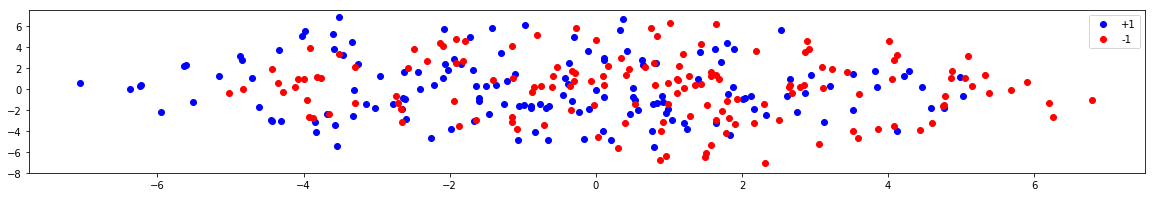

In [211]:
xxTr1 = np.append(xTr1, xTr3,axis=0)
yyTr1 = np.append(yTr1, yTr3)

print(xxTr1.shape)
print(yyTr1.shape)

plt.scatter(xTr1[:150, 0], xTr1[:150, 1], c='b')
#plt.show()
plt.scatter(xTr1[150:, 0], xTr1[150:, 1], c='r')
#plt.scatter(xTe1[:,0],xTe1[:,1],c='g')
plt.legend(["+1","-1","?"])
plt.figure(figsize=(10,10))
plt.show()

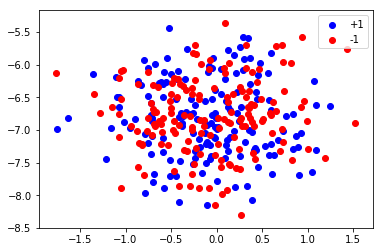

In [173]:
plt.scatter(xTr2[yTr2 == 1, 0], xTr2[yTr2 == 1, 1], c='b')
plt.scatter(xTr2[yTr2 != 1, 0], xTr2[yTr2 != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

In [174]:
xTr1.shape

(300, 2)

In [175]:
xTr2.shape

(320, 6)

In [ ]:
# xTr1 = np.array([[ 9.81895485e-01, -1.94028692e+00],
# [ 9.62086863e-01, -2.33193261e+00],
# [ 1.81487053e+00, -4.37475517e-01],
# [ 5.14162131e-01, 8.48259254e-02],
# [ 9.08241398e-01, -6.98205961e-01],
# [ 5.05587685e-01, -7.66978713e-01],
# [ 2.00916168e+00, -9.07317655e-01],
# [ 5.30113008e-01, -1.08245727e+00],
# [ 9.17856393e-01, -1.20543134e+00],
# [-9.80731692e-01, -1.51426211e+00],
# [ 4.60922571e-01, -2.36496863e+00],
# [-3.28845997e-01, -1.10563468e+00],
# [ 1.12800519e-01, -7.41533786e-01],
# [ 1.03951229e+00, -2.97014390e+00],
# [-6.83236857e-01, -1.77133897e+00],
# [ 5.76364446e-01, -2.00689771e+00],
# [-7.70564985e-01, -1.45854567e+00],
# [-1.05063808e+00, -1.61652401e+00],
# [-6.95920652e-05, -1.19931250e-01],
# [-9.24610660e-02, -1.86097069e+00],
# [ 7.81432925e-01, -1.44875721e+00],
# [ 8.35354561e-01, -1.35780473e+00],
# [-8.81789662e-01, -1.85167277e+00],
# [-1.46388947e+00, -2.37096968e+00],
# [-8.84771537e-01, -1.63895758e+00],
# [-1.60180525e+00, -1.13886568e+00],
# [-6.43068085e-01, -1.58682649e+00],
# [-1.60260008e+00, -8.88222027e-01],
# [-2.30375964e-01, -2.16288229e+00],
# [-2.65534432e+00, -1.86486356e+00],
# [-3.14857151e+00, -1.46741440e+00],
# [-1.25106312e+00, -1.44772516e+00],
# [-3.86187188e-01, 5.22661312e-01],
# [-4.51687945e-01, -5.93119908e-01],
# [-2.40749539e+00, -2.00967923e-02],
# [-2.61751616e+00, -9.86547539e-01],
# [-3.30389972e+00, -1.15026523e-01],
# [-2.63686859e+00, -8.68229458e-01],
# [-2.77043926e+00, -1.42366698e+00],
# [-1.36744491e+00, 4.36878328e-01],
# [-1.49930553e+00, 2.47145103e-01],
# [-1.63598415e+00, 2.60056982e-01],
# [-2.09429665e+00, 1.05332295e+00],
# [-3.25926225e+00, 2.39179377e+00],
# [-2.21363084e+00, 4.12111069e-01],
# [-2.43221212e+00, 1.58951275e+00],
# [-2.62097327e+00, 1.59342808e+00],
# [-1.21360087e+00, 7.97940822e-01],
# [-1.68741680e+00, 1.81919084e+00],
# [-2.95914066e+00, 1.23967955e+00],
# [-1.11275812e+00, 1.41301044e+00],
# [-2.02179418e+00, 1.83604468e+00],
# [-4.25028146e-01, 1.04518281e+00],
# [-1.94776081e+00, 2.84788059e+00],
# [-1.29564375e+00, 3.45049675e+00],
# [-2.92509288e-01, 4.98501672e+00],
# [-1.84515161e+00, 2.36313769e+00],
# [ 1.13520314e-01, 2.74734896e+00],
# [-2.05918318e+00, 2.38691294e+00],
# [-1.03190919e-01, 3.59524235e+00],
# [ 1.12031492e-01, 2.92295709e+00],
# [-3.73331557e-01, 2.48697307e+00],
# [ 1.79287143e+00, 4.42694935e+00],
# [ 1.41969102e+00, 3.51013941e+00],
# [ 4.24906475e-01, 3.67399858e+00],
# [ 1.63589771e+00, 3.87324062e+00],
# [ 2.53970556e+00, 5.68117219e+00],
# [ 6.28022495e-01, 2.79921024e+00],
# [ 1.89568334e+00, 3.80320535e+00],
# [ 1.71040423e+00, 2.55122709e+00],
# [ 1.39101375e+00, 1.00856505e+00],
# [ 8.27897657e-01, 2.48204391e+00],
# [ 6.51662436e-01, 2.29732394e+00],
# [ 2.66123589e+00, 9.59555605e-01],
# [ 4.28114506e+00, 1.70749918e+00],
# [ 2.93731047e+00, 1.31437548e+00],
# [ 1.88100916e+00, 1.73617954e-01],
# [ 4.21982244e+00, 1.21352973e+00],
# [ 3.20635065e+00, 2.90634062e-01],
# [ 3.81433313e+00, 1.71865712e+00],
# [ 3.51289476e+00, 1.42507433e+00],
# [ 3.85389936e+00, 2.37995887e-01],
# [ 2.85892088e+00, -3.42047954e-01],
# [ 4.98258539e+00, 1.12767368e+00],
# [ 2.61275442e+00, -6.35280928e-01],
# [ 5.01814254e+00, -6.36131592e-01],
# [ 4.45823319e+00, 2.15597508e-01],
# [ 4.75986710e+00, -1.85064491e+00],
# [ 2.12237113e+00, -6.79950332e-01],
# [ 2.75771965e+00, -2.15536975e+00],
# [ 4.58135670e+00, -1.84118412e+00],
# [ 3.51388892e+00, -1.95482860e+00],
# [ 2.04123960e+00, -8.65118717e-01],
# [ 2.32614348e+00, -2.49926866e+00],
# [ 2.16485662e+00, -1.86857570e+00],
# [ 4.11946213e+00, -3.97640904e+00],
# [ 3.11551849e+00, -3.17188205e+00],
# [ 1.25332500e+00, -3.83631593e+00],
# [ 1.83629282e+00, -4.38647364e+00],
# [ 1.19949280e+00, -3.20185472e+00],
# [ 1.64611016e+00, -3.21462244e+00],
# [ 7.94195378e-01, -5.56837600e+00],
# [ 2.11643668e-01, -4.85939239e+00],
# [ 7.70006942e-01, -4.05403076e+00],
# [-6.49245119e-01, -4.85313670e+00],
# [-1.56668227e-01, -4.72562248e+00],
# [-8.33271909e-01, -4.14326289e+00],
# [-1.05995891e+00, -4.87578507e+00],
# [ 9.74604093e-02, -4.04362195e+00],
# [-3.54712449e+00, -5.41389729e+00],
# [-1.66739244e+00, -3.04871651e+00],
# [-1.98887072e+00, -3.81926477e+00],
# [-3.82667767e+00, -4.10291274e+00],
# [-3.31666290e+00, -2.61497483e+00],
# [-2.25947743e+00, -4.67628278e+00],
# [-3.57473757e+00, -3.43558750e+00],
# [-2.59631363e+00, -2.89381346e+00],
# [-3.83948371e+00, -3.14941436e+00],
# [-4.30629975e+00, -3.09073684e+00],
# [-4.43097605e+00, -3.01100151e+00],
# [-3.02319473e+00, -1.85332012e+00],
# [-4.45020654e+00, -2.96107030e+00],
# [-4.61635627e+00, -1.72752191e+00],
# [-3.67314815e+00, -2.41137731e+00],
# [-5.95224304e+00, -2.17489001e+00],
# [-5.50982462e+00, -1.23689841e+00],
# [-6.22476837e+00, 4.13902034e-01],
# [-6.36804266e+00, 2.01437068e-02],
# [-6.24007644e+00, 2.89863508e-01],
# [-5.15819440e+00, 1.27386329e+00],
# [-7.06078895e+00, 6.11210962e-01],
# [-4.87531824e+00, 3.17499801e+00],
# [-4.83794612e+00, 2.79596670e+00],
# [-5.60743350e+00, 2.31882741e+00],
# [-4.70019521e+00, 1.01528233e+00],
# [-5.64103039e+00, 2.25086864e+00],
# [-4.34109772e+00, 3.73832646e+00],
# [-3.58102300e+00, 3.80076022e+00],
# [-3.33228044e+00, 4.45418038e+00],
# [-3.59371756e+00, 5.29383796e+00],
# [-4.02186194e+00, 5.05374618e+00],
# [-3.98469578e+00, 5.53780593e+00],
# [-3.46018741e+00, 3.29848393e+00],
# [-1.71565692e+00, 4.97934536e+00],
# [-3.51139915e+00, 6.85940336e+00],
# [-2.07400355e+00, 5.78281358e+00],
# [-1.41863408e+00, 5.86238529e+00],
# [-9.68280292e-01, 6.07825598e+00],
# [ 3.30133198e-01, 5.69109642e+00],
# [ 3.67602636e-01, 6.73887571e+00],
# [-7.50753772e-01, 2.56109269e-01],
# [-1.13347365e+00, 1.05150740e+00],
# [-1.40969001e+00, 8.44107171e-01],
# [ 1.02979767e-01, 1.29099233e+00],
# [-8.80463624e-01, -2.76430514e-01],
# [-6.49989140e-02, 7.58347871e-01],
# [-2.97548128e-01, 7.37983109e-01],
# [-3.53083656e-01, 2.72527924e-01],
# [-5.91124252e-01, 1.26209765e+00],
# [ 1.14223424e+00, 2.22619501e+00],
# [ 1.71529281e-01, 2.18425135e+00],
# [-3.22993772e-01, 1.70936819e+00],
# [-8.46394283e-01, 2.28789453e-01],
# [-6.03784287e-01, 1.59461650e-01],
# [-5.25338514e-01, 2.15380910e+00],
# [ 6.67510235e-01, 2.07193323e+00],
# [-2.91101942e-01, 1.51635002e+00],
# [ 1.12948887e+00, 8.70163740e-01],
# [ 4.15509279e-01, 1.34681259e+00],
# [ 7.94654277e-01, 2.46718005e+00],
# [ 1.27281710e+00, 1.22456835e+00],
# [ 1.10058805e-01, 4.28678197e-01],
# [ 1.19915708e+00, 3.37671657e+00],
# [ 1.58137915e+00, 1.28333294e+00],
# [ 9.92367805e-01, 5.71706616e-01],
# [ 1.57740769e+00, 1.60554548e+00],
# [ 4.56013771e-01, 1.89861228e+00],
# [ 8.14555685e-01, 4.19506308e-01],
# [ 1.68358311e+00, 9.29078406e-01],
# [ 1.21145271e+00, 1.38590605e-01],
# [ 1.44142943e+00, 5.00639671e-01],
# [ 1.11025491e+00, -3.67906431e-01],
# [ 1.11194848e+00, 9.20188213e-01],
# [ 1.64034910e+00, 1.39178789e+00],
# [ 3.23644620e+00, 1.93362430e+00],
# [ 4.05901116e+00, 1.00024848e+00],
# [ 2.85078666e+00, 4.27809506e-01],
# [ 2.64447170e+00, 1.92913584e-01],
# [ 2.67792339e+00, -3.50407316e-01],
# [ 3.10756732e+00, 1.49134340e-01],
# [ 2.78801675e+00, 2.14676716e-01],
# [ 2.30136062e+00, -1.44364658e+00],
# [ 2.65900441e+00, 4.17119002e-01],
# [ 1.52588003e+00, -1.52208357e+00],
# [ 3.60406843e+00, -4.88332643e-01],
# [ 2.16259842e+00, -3.20236361e+00],
# [ 1.36051179e+00, 4.29765133e-01],
# [ 1.92669804e+00, -9.52131581e-01],
# [ 1.81786234e+00, -2.75505153e+00],
# [ 9.88088204e-01, -1.43143039e+00],
# [ 1.72923295e+00, -2.13330673e+00],
# [ 2.50908547e+00, -2.97769825e+00],
# [ 1.78839183e+00, -1.12165652e+00],
# [ 1.90231681e+00, -3.30188222e+00],
# [ 9.14730745e-01, -3.13592796e+00],
# [-2.11125159e-02, -1.54899277e+00],
# [ 1.65076047e+00, -2.98891392e+00],
# [ 1.29163728e+00, -2.58292929e+00],
# [ 1.78122631e+00, -4.15760788e+00],
# [-1.15250777e+00, -2.66048773e+00],
# [ 5.28857124e-01, -1.47104482e+00],
# [ 4.02981420e-01, -3.23347791e+00],
# [ 8.93236548e-01, -3.96767273e+00],
# [-1.08261751e+00, -3.85290470e+00],
# [-1.14749416e+00, -3.10290520e+00],
# [-7.13330893e-01, -3.47754762e+00],
# [-3.46934265e-01, -2.01398800e+00],
# [-1.93854099e+00, -1.09619402e+00],
# [-2.65085789e+00, -3.13357569e+00],
# [-1.63383931e+00, -2.92397555e+00],
# [-3.64700089e+00, -2.42955462e+00],
# [-1.87698765e+00, -3.50064001e+00],
# [-2.70302966e+00, -1.37367791e+00],
# [-2.66133627e+00, -1.93084799e+00],
# [-3.87585874e+00, -2.73539690e+00],
# [-3.95299470e+00, -1.02428997e+00],
# [-3.93021929e+00, -2.68465810e+00],
# [-3.29910904e+00, -1.36219381e+00],
# [-4.82431436e+00, 2.79513606e-02],
# [-2.73979525e+00, -6.38975118e-01],
# [-4.28448507e+00, -3.22348891e-01],
# [-5.01358455e+00, -3.59620274e-01],
# [-4.12213795e+00, 2.01084778e-01],
# [-4.34528847e+00, 6.08614683e-01],
# [-3.75651518e+00, 1.08885398e+00],
# [-4.07093815e+00, 9.32339756e-01],
# [-3.99895023e+00, 9.87255638e-01],
# [-3.81446064e+00, 1.15930976e+00],
# [-3.29172961e+00, 2.10753938e+00],
# [-4.43170406e+00, 1.88424847e+00],
# [-2.57164075e+00, 2.03172694e+00],
# [-3.51135197e+00, 3.35252319e+00],
# [-3.91591278e+00, 3.94162263e+00],
# [-1.82206873e+00, 2.72400981e+00],
# [-1.91073683e+00, 2.46390360e+00],
# [-1.90736328e+00, 4.74833287e+00],
# [-2.49401553e+00, 3.85108111e+00],
# [-2.31279013e+00, 2.68270969e+00],
# [-1.15061458e+00, 4.12352432e+00],
# [-2.12682130e+00, 4.39557953e+00],
# [-2.09505402e+00, 4.13411884e+00],
# [-1.78402988e+00, 4.55945749e+00],
# [ 3.20110319e-03, 4.69351623e+00],
# [ 7.54503073e-01, 5.84751646e+00],
# [-2.73237333e-01, 5.86985032e+00],
# [ 3.49090608e-01, 3.01651517e+00],
# [ 8.37904599e-01, 5.05616334e+00],
# [ 1.63747161e+00, 6.17478959e+00],
# [-8.07033754e-01, 5.12927162e+00],
# [ 1.01264773e+00, 6.30808857e+00],
# [ 2.19273012e+00, 3.67358186e+00],
# [ 2.91794110e+00, 3.86630550e+00],
# [ 2.86557391e+00, 3.53745201e+00],
# [ 4.12002639e+00, 3.21131675e+00],
# [ 4.00568892e+00, 4.55787002e+00],
# [ 1.43868644e+00, 4.29048493e+00],
# [ 2.89320403e+00, 4.58819233e+00],
# [ 5.09702384e+00, 3.15142014e+00],
# [ 3.09592523e+00, 2.06463477e+00],
# [ 4.07912983e+00, 2.79306121e+00],
# [ 3.43666861e+00, 1.66023155e+00],
# [ 5.32262028e+00, 1.38004459e+00],
# [ 4.87045788e+00, 1.71345647e+00],
# [ 5.05377422e+00, 1.06273445e+00],
# [ 4.86304307e+00, 1.06929712e+00],
# [ 5.68193798e+00, -7.52527083e-02],
# [ 5.14726282e+00, 3.25107891e-01],
# [ 6.20649687e+00, -1.30814417e+00],
# [ 5.90099328e+00, 7.11185574e-01],
# [ 4.77653025e+00, -6.96456142e-01],
# [ 6.25451040e+00, -2.68974564e+00],
# [ 5.38110879e+00, -3.61383348e-01],
# [ 6.78407293e+00, -1.05080248e+00],
# [ 4.75708471e+00, -1.58266110e+00],
# [ 4.76139782e+00, -1.51832628e+00],
# [ 3.86275309e+00, -3.77850170e+00],
# [ 4.59349173e+00, -3.21423775e+00],
# [ 4.43203190e+00, -3.87008701e+00],
# [ 4.08173314e+00, -3.56492909e+00],
# [ 3.05976714e+00, -5.24068856e+00],
# [ 3.51963428e+00, -4.00337770e+00],
# [ 3.59278209e+00, -4.66660244e+00],
# [ 1.57699582e+00, -5.37925132e+00],
# [ 9.53848216e-01, -6.39973332e+00],
# [ 2.32050811e+00, -7.04384153e+00],
# [ 2.99883070e-01, -5.63602785e+00],
# [ 1.50924033e+00, -6.09105333e+00],
# [ 1.49797453e+00, -6.49443914e+00],
# [ 3.15264367e-02, -4.60666963e+00],
# [ 8.79827631e-01, -6.79448913e+00], 9.81895485e-01, -1.94028692e+00],
# [ 9.62086863e-01, -2.33193261e+00],
# [ 1.81487053e+00, -4.37475517e-01],
# [ 5.14162131e-01, 8.48259254e-02],
# [ 9.08241398e-01, -6.98205961e-01],
# [ 5.05587685e-01, -7.66978713e-01],
# [ 2.00916168e+00, -9.07317655e-01],
# [ 5.30113008e-01, -1.08245727e+00],
# [ 9.17856393e-01, -1.20543134e+00],
# [-9.80731692e-01, -1.51426211e+00],
# [ 4.60922571e-01, -2.36496863e+00],
# [-3.28845997e-01, -1.10563468e+00],
# [ 1.12800519e-01, -7.41533786e-01],
# [ 1.03951229e+00, -2.97014390e+00],
# [-6.83236857e-01, -1.77133897e+00],
# [ 5.76364446e-01, -2.00689771e+00],
# [-7.70564985e-01, -1.45854567e+00],
# [-1.05063808e+00, -1.61652401e+00],
# [-6.95920652e-05, -1.19931250e-01],
# [-9.24610660e-02, -1.86097069e+00],
# [ 7.81432925e-01, -1.44875721e+00],
# [ 8.35354561e-01, -1.35780473e+00],
# [-8.81789662e-01, -1.85167277e+00],
# [-1.46388947e+00, -2.37096968e+00],
# [-8.84771537e-01, -1.63895758e+00],
# [-1.60180525e+00, -1.13886568e+00],
# [-6.43068085e-01, -1.58682649e+00],
# [-1.60260008e+00, -8.88222027e-01],
# [-2.30375964e-01, -2.16288229e+00],
# [-2.65534432e+00, -1.86486356e+00],
# [-3.14857151e+00, -1.46741440e+00],
# [-1.25106312e+00, -1.44772516e+00],
# [-3.86187188e-01, 5.22661312e-01],
# [-4.51687945e-01, -5.93119908e-01],
# [-2.40749539e+00, -2.00967923e-02],
# [-2.61751616e+00, -9.86547539e-01],
# [-3.30389972e+00, -1.15026523e-01],
# [-2.63686859e+00, -8.68229458e-01],
# [-2.77043926e+00, -1.42366698e+00],
# [-1.36744491e+00, 4.36878328e-01],
# [-1.49930553e+00, 2.47145103e-01],
# [-1.63598415e+00, 2.60056982e-01],
# [-2.09429665e+00, 1.05332295e+00],
# [-3.25926225e+00, 2.39179377e+00],
# [-2.21363084e+00, 4.12111069e-01],
# [-2.43221212e+00, 1.58951275e+00],
# [-2.62097327e+00, 1.59342808e+00],
# [-1.21360087e+00, 7.97940822e-01],
# [-1.68741680e+00, 1.81919084e+00],
# [-2.95914066e+00, 1.23967955e+00],
# [-1.11275812e+00, 1.41301044e+00],
# [-2.02179418e+00, 1.83604468e+00],
# [-4.25028146e-01, 1.04518281e+00],
# [-1.94776081e+00, 2.84788059e+00],
# [-1.29564375e+00, 3.45049675e+00],
# [-2.92509288e-01, 4.98501672e+00],
# [-1.84515161e+00, 2.36313769e+00],
# [ 1.13520314e-01, 2.74734896e+00],
# [-2.05918318e+00, 2.38691294e+00],
# [-1.03190919e-01, 3.59524235e+00],
# [ 1.12031492e-01, 2.92295709e+00],
# [-3.73331557e-01, 2.48697307e+00],
# [ 1.79287143e+00, 4.42694935e+00],
# [ 1.41969102e+00, 3.51013941e+00],
# [ 4.24906475e-01, 3.67399858e+00],
# [ 1.63589771e+00, 3.87324062e+00],
# [ 2.53970556e+00, 5.68117219e+00],
# [ 6.28022495e-01, 2.79921024e+00],
# [ 1.89568334e+00, 3.80320535e+00],
# [ 1.71040423e+00, 2.55122709e+00],
# [ 1.39101375e+00, 1.00856505e+00],
# [ 8.27897657e-01, 2.48204391e+00],
# [ 6.51662436e-01, 2.29732394e+00],
# [ 2.66123589e+00, 9.59555605e-01],
# [ 4.28114506e+00, 1.70749918e+00],
# [ 2.93731047e+00, 1.31437548e+00],
# [ 1.88100916e+00, 1.73617954e-01],
# [ 4.21982244e+00, 1.21352973e+00],
# [ 3.20635065e+00, 2.90634062e-01],
# [ 3.81433313e+00, 1.71865712e+00],
# [ 3.51289476e+00, 1.42507433e+00],
# [ 3.85389936e+00, 2.37995887e-01],
# [ 2.85892088e+00, -3.42047954e-01],
# [ 4.98258539e+00, 1.12767368e+00],
# [ 2.61275442e+00, -6.35280928e-01],
# [ 5.01814254e+00, -6.36131592e-01],
# [ 4.45823319e+00, 2.15597508e-01],
# [ 4.75986710e+00, -1.85064491e+00],
# [ 2.12237113e+00, -6.79950332e-01],
# [ 2.75771965e+00, -2.15536975e+00],
# [ 4.58135670e+00, -1.84118412e+00],
# [ 3.51388892e+00, -1.95482860e+00],
# [ 2.04123960e+00, -8.65118717e-01],
# [ 2.32614348e+00, -2.49926866e+00],
# [ 2.16485662e+00, -1.86857570e+00],
# [ 4.11946213e+00, -3.97640904e+00],
# [ 3.11551849e+00, -3.17188205e+00],
# [ 1.25332500e+00, -3.83631593e+00],
# [ 1.83629282e+00, -4.38647364e+00],
# [ 1.19949280e+00, -3.20185472e+00],
# [ 1.64611016e+00, -3.21462244e+00],
# [ 7.94195378e-01, -5.56837600e+00],
# [ 2.11643668e-01, -4.85939239e+00],
# [ 7.70006942e-01, -4.05403076e+00],
# [-6.49245119e-01, -4.85313670e+00],
# [-1.56668227e-01, -4.72562248e+00],
# [-8.33271909e-01, -4.14326289e+00],
# [-1.05995891e+00, -4.87578507e+00],
# [ 9.74604093e-02, -4.04362195e+00],
# [-3.54712449e+00, -5.41389729e+00],
# [-1.66739244e+00, -3.04871651e+00],
# [-1.98887072e+00, -3.81926477e+00],
# [-3.82667767e+00, -4.10291274e+00],
# [-3.31666290e+00, -2.61497483e+00],
# [-2.25947743e+00, -4.67628278e+00],
# [-3.57473757e+00, -3.43558750e+00],
# [-2.59631363e+00, -2.89381346e+00],
# [-3.83948371e+00, -3.14941436e+00],
# [-4.30629975e+00, -3.09073684e+00],
# [-4.43097605e+00, -3.01100151e+00],
# [-3.02319473e+00, -1.85332012e+00],
# [-4.45020654e+00, -2.96107030e+00],
# [-4.61635627e+00, -1.72752191e+00],
# [-3.67314815e+00, -2.41137731e+00],
# [-5.95224304e+00, -2.17489001e+00],
# [-5.50982462e+00, -1.23689841e+00],
# [-6.22476837e+00, 4.13902034e-01],
# [-6.36804266e+00, 2.01437068e-02],
# [-6.24007644e+00, 2.89863508e-01],
# [-5.15819440e+00, 1.27386329e+00],
# [-7.06078895e+00, 6.11210962e-01],
# [-4.87531824e+00, 3.17499801e+00],
# [-4.83794612e+00, 2.79596670e+00],
# [-5.60743350e+00, 2.31882741e+00],
# [-4.70019521e+00, 1.01528233e+00],
# [-5.64103039e+00, 2.25086864e+00],
# [-4.34109772e+00, 3.73832646e+00],
# [-3.58102300e+00, 3.80076022e+00],
# [-3.33228044e+00, 4.45418038e+00],
# [-3.59371756e+00, 5.29383796e+00],
# [-4.02186194e+00, 5.05374618e+00],
# [-3.98469578e+00, 5.53780593e+00],
# [-3.46018741e+00, 3.29848393e+00],
# [-1.71565692e+00, 4.97934536e+00],
# [-3.51139915e+00, 6.85940336e+00],
# [-2.07400355e+00, 5.78281358e+00],
# [-1.41863408e+00, 5.86238529e+00],
# [-9.68280292e-01, 6.07825598e+00],
# [ 3.30133198e-01, 5.69109642e+00],
# [ 3.67602636e-01, 6.73887571e+00],
# [-7.50753772e-01, 2.56109269e-01],
# [-1.13347365e+00, 1.05150740e+00],
# [-1.40969001e+00, 8.44107171e-01],
# [ 1.02979767e-01, 1.29099233e+00],
# [-8.80463624e-01, -2.76430514e-01],
# [-6.49989140e-02, 7.58347871e-01],
# [-2.97548128e-01, 7.37983109e-01],
# [-3.53083656e-01, 2.72527924e-01],
# [-5.91124252e-01, 1.26209765e+00],
# [ 1.14223424e+00, 2.22619501e+00],
# [ 1.71529281e-01, 2.18425135e+00],
# [-3.22993772e-01, 1.70936819e+00],
# [-8.46394283e-01, 2.28789453e-01],
# [-6.03784287e-01, 1.59461650e-01],
# [-5.25338514e-01, 2.15380910e+00],
# [ 6.67510235e-01, 2.07193323e+00],
# [-2.91101942e-01, 1.51635002e+00],
# [ 1.12948887e+00, 8.70163740e-01],
# [ 4.15509279e-01, 1.34681259e+00],
# [ 7.94654277e-01, 2.46718005e+00],
# [ 1.27281710e+00, 1.22456835e+00],
# [ 1.10058805e-01, 4.28678197e-01],
# [ 1.19915708e+00, 3.37671657e+00],
# [ 1.58137915e+00, 1.28333294e+00],
# [ 9.92367805e-01, 5.71706616e-01],
# [ 1.57740769e+00, 1.60554548e+00],
# [ 4.56013771e-01, 1.89861228e+00],
# [ 8.14555685e-01, 4.19506308e-01],
# [ 1.68358311e+00, 9.29078406e-01],
# [ 1.21145271e+00, 1.38590605e-01],
# [ 1.44142943e+00, 5.00639671e-01],
# [ 1.11025491e+00, -3.67906431e-01],
# [ 1.11194848e+00, 9.20188213e-01],
# [ 1.64034910e+00, 1.39178789e+00],
# [ 3.23644620e+00, 1.93362430e+00],
# [ 4.05901116e+00, 1.00024848e+00],
# [ 2.85078666e+00, 4.27809506e-01],
# [ 2.64447170e+00, 1.92913584e-01],
# [ 2.67792339e+00, -3.50407316e-01],
# [ 3.10756732e+00, 1.49134340e-01],
# [ 2.78801675e+00, 2.14676716e-01],
# [ 2.30136062e+00, -1.44364658e+00],
# [ 2.65900441e+00, 4.17119002e-01],
# [ 1.52588003e+00, -1.52208357e+00],
# [ 3.60406843e+00, -4.88332643e-01],
# [ 2.16259842e+00, -3.20236361e+00],
# [ 1.36051179e+00, 4.29765133e-01],
# [ 1.92669804e+00, -9.52131581e-01],
# [ 1.81786234e+00, -2.75505153e+00],
# [ 9.88088204e-01, -1.43143039e+00],
# [ 1.72923295e+00, -2.13330673e+00],
# [ 2.50908547e+00, -2.97769825e+00],
# [ 1.78839183e+00, -1.12165652e+00],
# [ 1.90231681e+00, -3.30188222e+00],
# [ 9.14730745e-01, -3.13592796e+00],
# [-2.11125159e-02, -1.54899277e+00],
# [ 1.65076047e+00, -2.98891392e+00],
# [ 1.29163728e+00, -2.58292929e+00],
# [ 1.78122631e+00, -4.15760788e+00],
# [-1.15250777e+00, -2.66048773e+00],
# [ 5.28857124e-01, -1.47104482e+00],
# [ 4.02981420e-01, -3.23347791e+00],
# [ 8.93236548e-01, -3.96767273e+00],
# [-1.08261751e+00, -3.85290470e+00],
# [-1.14749416e+00, -3.10290520e+00],
# [-7.13330893e-01, -3.47754762e+00],
# [-3.46934265e-01, -2.01398800e+00],
# [-1.93854099e+00, -1.09619402e+00],
# [-2.65085789e+00, -3.13357569e+00],
# [-1.63383931e+00, -2.92397555e+00],
# [-3.64700089e+00, -2.42955462e+00],
# [-1.87698765e+00, -3.50064001e+00],
# [-2.70302966e+00, -1.37367791e+00],
# [-2.66133627e+00, -1.93084799e+00],
# [-3.87585874e+00, -2.73539690e+00],
# [-3.95299470e+00, -1.02428997e+00],
# [-3.93021929e+00, -2.68465810e+00],
# [-3.29910904e+00, -1.36219381e+00],
# [-4.82431436e+00, 2.79513606e-02],
# [-2.73979525e+00, -6.38975118e-01],
# [-4.28448507e+00, -3.22348891e-01],
# [-5.01358455e+00, -3.59620274e-01],
# [-4.12213795e+00, 2.01084778e-01],
# [-4.34528847e+00, 6.08614683e-01],
# [-3.75651518e+00, 1.08885398e+00],
# [-4.07093815e+00, 9.32339756e-01],
# [-3.99895023e+00, 9.87255638e-01],
# [-3.81446064e+00, 1.15930976e+00],
# [-3.29172961e+00, 2.10753938e+00],
# [-4.43170406e+00, 1.88424847e+00],
# [-2.57164075e+00, 2.03172694e+00],
# [-3.51135197e+00, 3.35252319e+00],
# [-3.91591278e+00, 3.94162263e+00],
# [-1.82206873e+00, 2.72400981e+00],
# [-1.91073683e+00, 2.46390360e+00],
# [-1.90736328e+00, 4.74833287e+00],
# [-2.49401553e+00, 3.85108111e+00],
# [-2.31279013e+00, 2.68270969e+00],
# [-1.15061458e+00, 4.12352432e+00],
# [-2.12682130e+00, 4.39557953e+00],
# [-2.09505402e+00, 4.13411884e+00],
# [-1.78402988e+00, 4.55945749e+00],
# [ 3.20110319e-03, 4.69351623e+00],
# [ 7.54503073e-01, 5.84751646e+00],
# [-2.73237333e-01, 5.86985032e+00],
# [ 3.49090608e-01, 3.01651517e+00],
# [ 8.37904599e-01, 5.05616334e+00],
# [ 1.63747161e+00, 6.17478959e+00],
# [-8.07033754e-01, 5.12927162e+00],
# [ 1.01264773e+00, 6.30808857e+00],
# [ 2.19273012e+00, 3.67358186e+00],
# [ 2.91794110e+00, 3.86630550e+00],
# [ 2.86557391e+00, 3.53745201e+00],
# [ 4.12002639e+00, 3.21131675e+00],
# [ 4.00568892e+00, 4.55787002e+00],
# [ 1.43868644e+00, 4.29048493e+00],
# [ 2.89320403e+00, 4.58819233e+00],
# [ 5.09702384e+00, 3.15142014e+00],
# [ 3.09592523e+00, 2.06463477e+00],
# [ 4.07912983e+00, 2.79306121e+00],
# [ 3.43666861e+00, 1.66023155e+00],
# [ 5.32262028e+00, 1.38004459e+00],
# [ 4.87045788e+00, 1.71345647e+00],
# [ 5.05377422e+00, 1.06273445e+00],
# [ 4.86304307e+00, 1.06929712e+00],
# [ 5.68193798e+00, -7.52527083e-02],
# [ 5.14726282e+00, 3.25107891e-01],
# [ 6.20649687e+00, -1.30814417e+00],
# [ 5.90099328e+00, 7.11185574e-01],
# [ 4.77653025e+00, -6.96456142e-01],
# [ 6.25451040e+00, -2.68974564e+00],
# [ 5.38110879e+00, -3.61383348e-01],
# [ 6.78407293e+00, -1.05080248e+00],
# [ 4.75708471e+00, -1.58266110e+00],
# [ 4.76139782e+00, -1.51832628e+00],
# [ 3.86275309e+00, -3.77850170e+00],
# [ 4.59349173e+00, -3.21423775e+00],
# [ 4.43203190e+00, -3.87008701e+00],
# [ 4.08173314e+00, -3.56492909e+00],
# [ 3.05976714e+00, -5.24068856e+00],
# [ 3.51963428e+00, -4.00337770e+00],
# [ 3.59278209e+00, -4.66660244e+00],
# [ 1.57699582e+00, -5.37925132e+00],
# [ 9.53848216e-01, -6.39973332e+00],
# [ 2.32050811e+00, -7.04384153e+00],
# [ 2.99883070e-01, -5.63602785e+00],
# [ 1.50924033e+00, -6.09105333e+00],
# [ 1.49797453e+00, -6.49443914e+00],
# [ 3.15264367e-02, -4.60666963e+00],
# [ 8.79827631e-01, -6.79448913e+00]])
# yTr1 = np.array([ 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
# 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
# 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
# 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
# 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
# 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
# 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
# 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
# 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
# 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
# -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
# -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
# -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
# -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
# -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
# -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
# -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
# -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
# -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
# -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])
# xTr2 = np.array([[ 1.32313664e-02, -6.81428169e+00, 2.37979619e-01, -1.84782205e+01,
# 6.74661646e+00, -1.35010299e+01],
# [-1.36534333e-01, -6.84104649e+00, 7.29335200e-01, -1.84500334e+01,
# 6.23258220e+00, -1.34090378e+01],
# [-3.57531782e-01, -7.29807194e+00, 1.21728357e+00, -1.80587660e+01,
# 6.85133488e+00, -1.26583580e+01],
# [-6.32605754e-01, -6.86547663e+00, 8.98867274e-01, -1.83912097e+01,
# 6.02773365e+00, -1.32219682e+01],
# [ 1.36801118e-01, -7.52590136e+00, 6.96636470e-01, -1.85413733e+01,
# 6.61982935e+00, -1.27196558e+01],
# [ 1.08724179e+00, -7.30821987e+00, 1.48439411e+00, -1.79584938e+01,
# 6.20207762e+00, -1.24625286e+01],
# [ 3.07550742e-01, -7.17850688e+00, 7.51631505e-01, -1.85532149e+01,
# 6.01777779e+00, -1.29433095e+01],
# [ 8.96725676e-01, -7.26068093e+00, 9.25606995e-01, -1.82599159e+01,
# 5.65629400e+00, -1.30659654e+01],
# [ 6.10271088e-01, -7.67921634e+00, 1.51636154e+00, -1.84379477e+01,
# 6.01455747e+00, -1.25328497e+01],
# [ 1.04397399e+00, -7.64113153e+00, 8.71352247e-01, -1.84533974e+01,
# 5.80519499e+00, -1.29522617e+01],
# [-7.12169262e-01, -7.09478610e+00, 5.52950875e-01, -1.80273315e+01,
# 5.97385695e+00, -1.30734327e+01],
# [-5.82768464e-01, -7.88825625e+00, -1.09404965e-01, -1.80815588e+01,
# 6.13790491e+00, -1.27397280e+01],
# [-1.21158787e-01, -7.49785486e+00, -3.76078708e-01, -1.81963789e+01,
# 6.24489757e+00, -1.24458307e+01],
# [-2.42366764e-01, -7.41987663e+00, 4.48565604e-02, -1.75413585e+01,
# 6.38887974e+00, -1.30592123e+01],
# [-1.57173759e-01, -7.65426423e+00, 1.77367383e-01, -1.83668817e+01,
# 6.31437562e+00, -1.30232245e+01],
# [-1.97986505e-02, -7.38696840e+00, 6.25062658e-02, -1.77353246e+01,
# 5.59754004e+00, -1.27008054e+01],
# [ 2.59659423e-01, -6.85202962e+00, 3.42290392e-01, -1.80622966e+01,
# 5.81735946e+00, -1.25015759e+01],
# [ 4.01609330e-01, -7.34490338e+00, 8.26350440e-01, -1.74483431e+01,
# 5.54748679e+00, -1.30815389e+01],
# [ 4.25714527e-01, -7.44641551e+00, 2.72783195e-01, -1.76105126e+01,
# 5.62323262e+00, -1.16908262e+01],
# [ 1.10297863e-01, -7.91893459e+00, 2.24471784e-01, -1.79340997e+01,
# 5.81795079e+00, -1.26393558e+01],
# [-8.28076166e-02, -6.02203081e+00, 1.22729938e+00, -1.82046558e+01,
# 6.83330570e+00, -1.38339277e+01],
# [-3.52046749e-01, -6.22387068e+00, 9.90375577e-01, -1.78051609e+01,
# 6.73173305e+00, -1.36249283e+01],
# [-4.32958572e-01, -6.21885171e+00, 1.03101778e+00, -1.82014851e+01,
# 6.46932682e+00, -1.36411214e+01],
# [-2.81658444e-01, -6.53062333e+00, 5.76537170e-01, -1.81423468e+01,
# 6.89894783e+00, -1.33657969e+01],
# [-1.22852726e-01, -6.56260858e+00, 1.28944804e+00, -1.75945639e+01,
# 6.61717698e+00, -1.34361551e+01],
# [ 7.40858275e-01, -6.41024644e+00, 1.06741290e+00, -1.76183275e+01,
# 6.18665633e+00, -1.32421042e+01],
# [ 5.14033860e-01, -6.82713370e+00, 9.39315635e-01, -1.74125126e+01,
# 5.50616363e+00, -1.31904259e+01],
# [ 3.83631154e-01, -6.10927137e+00, 8.21736381e-01, -1.78808262e+01,
# 5.61274188e+00, -1.28380685e+01],
# [ 4.59718084e-01, -6.06159426e+00, 1.15919477e+00, -1.77252401e+01,
# 5.07926068e+00, -1.31041709e+01],
# [ 2.80148366e-01, -6.40889793e+00, 9.17648945e-01, -1.79061492e+01,
# 5.52552607e+00, -1.32231837e+01],
# [-6.14271632e-01, -6.90681533e+00, 3.45892364e-01, -1.71643909e+01,
# 6.21482903e+00, -1.28997183e+01],
# [-3.71623232e-01, -6.32778627e+00, 2.42429043e-01, -1.77672277e+01,
# 6.17418767e+00, -1.29567245e+01],
# [-6.94969196e-01, -6.67937691e+00, 3.83680442e-01, -1.76552610e+01,
# 6.09745778e+00, -1.33230256e+01],
# [-4.29553584e-01, -6.49441976e+00, 2.44607886e-01, -1.72798385e+01,
# 6.10542071e+00, -1.31837973e+01],
# [-7.01632946e-01, -6.31847088e+00, -1.50706108e-01, -1.79913626e+01,
# 5.73900132e+00, -1.30222844e+01],
# [ 3.50061154e-01, -7.00534074e+00, 1.21092861e-01, -1.74412813e+01,
# 5.34048949e+00, -1.31860238e+01],
# [ 4.38379051e-01, -6.52990323e+00, 4.48792678e-01, -1.74903310e+01,
# 5.44922158e+00, -1.27331967e+01],
# [-6.19098482e-02, -6.88879790e+00, -2.52734067e-01, -1.77638765e+01,
# 5.28301255e+00, -1.30454572e+01],
# [-4.83254054e-02, -6.76978480e+00, 5.95181660e-01, -1.71809792e+01,
# 5.37773821e+00, -1.31348506e+01],
# [-2.62704427e-04, -6.97852353e+00, 5.35440847e-01, -1.74357508e+01,
# 5.62859356e+00, -1.33102730e+01],
# [ 5.70061491e-01, -7.38646123e+00, 7.94384714e-01, -1.75451166e+01,
# 7.74033557e+00, -1.27873437e+01],
# [ 6.78082987e-01, -7.14922752e+00, 6.91986637e-01, -1.75095120e+01,
# 7.21484779e+00, -1.25467875e+01],
# [ 4.37120571e-01, -7.31199441e+00, 1.19617317e+00, -1.76625230e+01,
# 7.35248509e+00, -1.27536257e+01],
# [ 2.53835367e-01, -7.39764036e+00, 8.89685891e-01, -1.76330405e+01,
# 7.11877071e+00, -1.33112980e+01],
# [ 5.30202043e-01, -7.24306787e+00, 7.03461504e-01, -1.74476259e+01,
# 6.97602188e+00, -1.30570920e+01],
# [ 1.18463091e+00, -7.43363868e+00, 7.61444883e-01, -1.68173715e+01,
# 6.40409209e+00, -1.27333469e+01],
# [ 7.27600411e-01, -7.18333680e+00, 1.45196348e+00, -1.76999347e+01,
# 6.65975889e+00, -1.26582278e+01],
# [ 1.52328825e+00, -6.88792640e+00, 1.02526771e+00, -1.75817762e+01,
# 6.58164444e+00, -1.27214379e+01],
# [ 6.07446628e-01, -7.04897097e+00, 1.11795423e+00, -1.74449130e+01,
# 6.74515481e+00, -1.27026732e+01],
# [ 9.54868734e-01, -6.55364267e+00, 1.51202496e+00, -1.72643981e+01,
# 7.04963218e+00, -1.25338012e+01],
# [-1.77477060e-02, -8.15296193e+00, 3.71403812e-01, -1.73560591e+01,
# 6.78387340e+00, -1.28530240e+01],
# [ 1.46541147e-01, -7.53746224e+00, 4.69519473e-01, -1.70635259e+01,
# 6.53070094e+00, -1.26019767e+01],
# [-1.89934923e-01, -7.88703456e+00, 6.55220823e-01, -1.72519027e+01,
# 6.31556610e+00, -1.25643761e+01],
# [-6.75954046e-01, -6.93650388e+00, 5.41084455e-02, -1.68453312e+01,
# 7.11065566e+00, -1.24110057e+01],
# [ 4.87636854e-02, -7.45525187e+00, 2.28879193e-01, -1.77532942e+01,
# 6.98222444e+00, -1.28680960e+01],
# [ 3.34252528e-01, -7.85570538e+00, 1.53775692e-01, -1.72198410e+01,
# 6.14694476e+00, -1.26680348e+01],
# [ 4.07289614e-01, -7.30325924e+00, 4.08359444e-01, -1.70104006e+01,
# 5.87171993e+00, -1.25551964e+01],
# [ 8.80969472e-02, -7.42069536e+00, 5.51108518e-01, -1.63397153e+01,
# 6.32269865e+00, -1.29223516e+01],
# [ 4.57016106e-01, -7.56193810e+00, 5.06689588e-01, -1.75325093e+01,
# 6.09804818e+00, -1.26017966e+01],
# [ 9.06173411e-01, -7.68815399e+00, 8.38519092e-01, -1.72696213e+01,
# 6.37505688e+00, -1.20253896e+01],
# [ 1.50510311e-01, -6.89310694e+00, 1.04505542e+00, -1.74032344e+01,
# 6.57196820e+00, -1.34791864e+01],
# [-1.92165115e-01, -6.52275452e+00, 7.99948920e-01, -1.71347033e+01,
# 6.82422259e+00, -1.34102810e+01],
# [ 3.44113348e-01, -6.74861656e+00, 1.13913597e+00, -1.74315297e+01,
# 7.64552917e+00, -1.31603718e+01],
# [ 1.18750144e-01, -6.49867992e+00, 1.11760985e+00, -1.70218416e+01,
# 6.64879688e+00, -1.33488616e+01],
# [-2.70991932e-01, -6.44484013e+00, 8.33945403e-01, -1.73799823e+01,
# 6.57980530e+00, -1.35263694e+01],
# [ 5.66620111e-01, -6.12510333e+00, 8.61006796e-01, -1.71737915e+01,
# 6.25602388e+00, -1.34860391e+01],
# [ 5.69552529e-01, -6.54541542e+00, 1.63939910e+00, -1.68191404e+01,
# 5.98985107e+00, -1.28565164e+01],
# [ 1.24124640e+00, -6.63185149e+00, 1.37824471e+00, -1.74637800e+01,
# 6.53987816e+00, -1.37378302e+01],
# [ 6.01893602e-01, -6.69565416e+00, 7.32920491e-01, -1.68277170e+01,
# 6.31298934e+00, -1.29349384e+01],
# [ 3.66982653e-01, -6.29834461e+00, 1.31723853e+00, -1.71821544e+01,
# 6.68093626e+00, -1.30126620e+01],
# [-2.62766645e-01, -6.74186739e+00, 2.16172394e-01, -1.70036577e+01,
# 6.27080685e+00, -1.30030256e+01],
# [-1.80362560e-02, -6.95018064e+00, 2.94028735e-01, -1.69470811e+01,
# 7.01575076e+00, -1.27160151e+01],
# [-1.77739888e-01, -7.26319810e+00, 3.96943675e-01, -1.71297547e+01,
# 6.56256637e+00, -1.32453870e+01],
# [-1.89749409e-01, -7.13071470e+00, 1.90860551e-01, -1.66432257e+01,
# 6.73249085e+00, -1.25606455e+01],
# [-3.35304493e-01, -6.71815675e+00, 4.93153038e-01, -1.69056855e+01,
# 6.92961764e+00, -1.32078708e+01],
# [ 6.47607361e-01, -6.70582615e+00, 2.02533216e-01, -1.68056889e+01,
# 6.04917810e+00, -1.26563179e+01],
# [ 2.97405190e-02, -6.96617478e+00, 2.50240985e-01, -1.62298644e+01,
# 6.11743617e+00, -1.28714606e+01],
# [ 3.86164833e-01, -6.87456706e+00, 7.76261365e-01, -1.62020470e+01,
# 5.94500801e+00, -1.28744602e+01],
# [ 4.10013372e-01, -6.94261005e+00, -1.10906150e-01, -1.63743840e+01,
# 6.32059229e+00, -1.30969797e+01],
# [ 6.99475986e-01, -7.32753583e+00, 2.44140883e-01, -1.65438079e+01,
# 6.28480082e+00, -1.29978991e+01],
# [-7.00239524e-01, -7.79656334e+00, 1.39622439e+00, -1.77095922e+01,
# 6.40658062e+00, -1.27263088e+01],
# [-7.10017152e-01, -6.85431133e+00, 1.26002838e+00, -1.77257288e+01,
# 6.82352649e+00, -1.27278190e+01],
# [-5.08729466e-01, -7.45529605e+00, 1.82066590e+00, -1.77228698e+01,
# 6.23626651e+00, -1.29103816e+01],
# [-4.06765790e-01, -7.47572326e+00, 1.82993026e+00, -1.84363338e+01,
# 5.94588833e+00, -1.23675123e+01],
# [-5.11691699e-01, -7.70223058e+00, 1.72981300e+00, -1.79263737e+01,
# 6.37774856e+00, -1.22772865e+01],
# [ 1.90286002e-01, -7.10596807e+00, 1.56812299e+00, -1.80105842e+01,
# 6.13061314e+00, -1.21013292e+01],
# [ 2.48947026e-01, -7.29238961e+00, 2.11858867e+00, -1.78146044e+01,
# 5.84244123e+00, -1.25602624e+01],
# [-8.10118230e-02, -7.88194851e+00, 1.61344285e+00, -1.78132528e+01,
# 6.10766455e+00, -1.20308541e+01],
# [-3.23884104e-01, -7.31348002e+00, 1.68798886e+00, -1.80773143e+01,
# 5.99747878e+00, -1.26779561e+01],
# [-4.67022489e-01, -6.86585462e+00, 1.60235812e+00, -1.78056451e+01,
# 5.89756151e+00, -1.23648550e+01],
# [-8.23773931e-01, -7.20871553e+00, 7.34898681e-01, -1.72643018e+01,
# 5.93290305e+00, -1.23117006e+01],
# [-7.94495114e-01, -7.68816355e+00, 4.64048916e-01, -1.78097419e+01,
# 6.13345306e+00, -1.22820522e+01],
# [-1.05430029e+00, -7.88274475e+00, 7.40673265e-01, -1.73724556e+01,
# 6.23079295e+00, -1.25489637e+01],
# [-8.58986283e-01, -7.56734754e+00, 4.89270223e-01, -1.73489607e+01,
# 5.87066672e+00, -1.22668186e+01],
# [-1.07677177e+00, -7.10955446e+00, 1.32151032e+00, -1.77560853e+01,
# 6.17575003e+00, -1.23611400e+01],
# [-2.53899646e-01, -7.52671650e+00, 8.28126642e-01, -1.74888923e+01,
# 5.27879600e+00, -1.23592693e+01],
# [ 3.67053112e-03, -7.77579718e+00, 5.38971913e-01, -1.75592270e+01,
# 6.22866543e+00, -1.23701330e+01],
# [-1.33160404e-02, -7.11857190e+00, 8.79760088e-01, -1.77187675e+01,
# 5.49636861e+00, -1.21704444e+01],
# [-4.13663738e-01, -8.09841178e+00, 9.17500194e-01, -1.73475372e+01,
# 5.67811477e+00, -1.22246990e+01],
# [-1.07668864e-01, -8.14023126e+00, 6.48406494e-01, -1.78043856e+01,
# 5.73005296e+00, -1.25852296e+01],
# [-1.07262198e+00, -6.20433857e+00, 1.88639689e+00, -1.81337150e+01,
# 6.12992634e+00, -1.39333970e+01],
# [-6.03753025e-01, -7.02714955e+00, 9.80955092e-01, -1.73855916e+01,
# 6.12785817e+00, -1.31057494e+01],
# [-8.70832640e-01, -7.01043612e+00, 1.82764086e+00, -1.72513571e+01,
# 6.09747382e+00, -1.29181553e+01],
# [-9.44724717e-01, -6.94456188e+00, 1.16655717e+00, -1.76948399e+01,
# 5.94903364e+00, -1.32665619e+01],
# [-1.04412479e+00, -6.10228674e+00, 2.05389101e+00, -1.77551984e+01,
# 6.42451542e+00, -1.29585855e+01],
# [-5.42715113e-02, -6.52564727e+00, 1.40676408e+00, -1.78740339e+01,
# 5.74901967e+00, -1.30452692e+01],
# [ 2.27117662e-01, -6.41296187e+00, 1.70490194e+00, -1.76980617e+01,
# 5.87760718e+00, -1.24681360e+01],
# [-1.42592645e-01, -6.85929711e+00, 1.56063906e+00, -1.74460695e+01,
# 5.72762446e+00, -1.21409085e+01],
# [-2.34433302e-01, -6.61949209e+00, 1.86878969e+00, -1.76544707e+01,
# 5.70926419e+00, -1.29772121e+01],
# [-3.82251841e-01, -6.93748996e+00, 1.82497987e+00, -1.74528749e+01,
# 6.12627920e+00, -1.25459140e+01],
# [-7.83292665e-01, -7.05463782e+00, 8.46617312e-01, -1.69670288e+01,
# 6.06877165e+00, -1.25009225e+01],
# [-8.96165168e-01, -6.83684709e+00, 6.15525749e-01, -1.70421462e+01,
# 5.83669726e+00, -1.21725933e+01],
# [-1.09200081e+00, -6.50168430e+00, 9.35152945e-01, -1.75862411e+01,
# 6.11485829e+00, -1.29588495e+01],
# [-1.63585417e+00, -6.81633714e+00, 9.02688707e-01, -1.73217500e+01,
# 6.04770633e+00, -1.29461253e+01],
# [-1.74868768e+00, -6.98113109e+00, 9.66626183e-01, -1.71613658e+01,
# 6.01247603e+00, -1.27426257e+01],
# [-8.14720819e-01, -7.22700601e+00, 9.30606208e-01, -1.65120831e+01,
# 4.97422694e+00, -1.26599527e+01],
# [-7.05636115e-01, -7.07175830e+00, 1.00982251e+00, -1.70605483e+01,
# 5.32515041e+00, -1.18282074e+01],
# [-7.21670820e-01, -6.58063972e+00, 1.33802111e+00, -1.71875066e+01,
# 5.91974568e+00, -1.25402707e+01],
# [-4.95570380e-01, -6.74232875e+00, 9.11523322e-01, -1.71126171e+01,
# 5.14975479e+00, -1.22703549e+01],
# [-5.90421013e-01, -6.81445096e+00, 8.98754579e-01, -1.67248520e+01,
# 5.13376162e+00, -1.25512554e+01],
# [-4.12780761e-01, -7.85990147e+00, 1.66740452e+00, -1.70482945e+01,
# 6.57257800e+00, -1.24719506e+01],
# [-2.22520946e-01, -7.27009412e+00, 1.68173467e+00, -1.73001625e+01,
# 7.06691556e+00, -1.25969264e+01],
# [-4.63823157e-01, -7.62234403e+00, 1.69388286e+00, -1.70337572e+01,
# 6.97783845e+00, -1.29955684e+01],
# [-3.17650615e-01, -7.16250087e+00, 1.13880827e+00, -1.73812438e+01,
# 7.37833958e+00, -1.23721633e+01],
# [ 4.61254490e-02, -7.56208492e+00, 1.54069686e+00, -1.74351021e+01,
# 6.67777130e+00, -1.25587482e+01],
# [ 1.97737618e-01, -7.87236092e+00, 1.45492839e+00, -1.74567894e+01,
# 6.03297152e+00, -1.23188506e+01],
# [ 3.91744803e-01, -8.07429262e+00, 1.77507439e+00, -1.75343529e+01,
# 6.28234130e+00, -1.28609650e+01],
# [ 7.29610486e-01, -7.01274873e+00, 1.47386760e+00, -1.73820374e+01,
# 5.89196453e+00, -1.27241125e+01],
# [ 8.34976577e-01, -7.28692711e+00, 1.41733765e+00, -1.72389345e+01,
# 6.76043165e+00, -1.22409435e+01],
# [ 4.17057759e-01, -7.27531953e+00, 1.84133658e+00, -1.71647475e+01,
# 5.78916227e+00, -1.25775940e+01],
# [-6.90378273e-01, -7.67379126e+00, 6.74681014e-01, -1.67038069e+01,
# 6.36543777e+00, -1.23568494e+01],
# [-7.89484110e-01, -7.96081276e+00, 1.26729300e+00, -1.70406610e+01,
# 6.92404950e+00, -1.28065188e+01],
# [-1.21606217e+00, -7.43822878e+00, 6.12772207e-01, -1.67524717e+01,
# 6.24179487e+00, -1.20015229e+01],
# [-7.18598499e-01, -7.35884266e+00, 1.01697693e+00, -1.71073195e+01,
# 6.39693585e+00, -1.23189257e+01],
# [-4.44467182e-01, -7.70080287e+00, 1.30434623e+00, -1.70476403e+01,
# 6.72646734e+00, -1.25802710e+01],
# [ 6.07556192e-02, -7.97217971e+00, 1.07131921e+00, -1.68442326e+01,
# 5.96416571e+00, -1.24313753e+01],
# [ 2.61125017e-01, -7.59446014e+00, 9.40789238e-01, -1.64588625e+01,
# 6.03898251e+00, -1.18832671e+01],
# [-2.90663483e-01, -7.86272690e+00, 5.66686721e-01, -1.64236068e+01,
# 6.05510288e+00, -1.21894193e+01],
# [ 2.72134720e-01, -8.30206491e+00, 1.31645135e+00, -1.68473608e+01,
# 5.54723523e+00, -1.17738375e+01],
# [-2.65008861e-01, -7.67360495e+00, 9.25676933e-01, -1.69887702e+01,
# 5.73297835e+00, -1.17707810e+01],
# [-7.15775609e-01, -6.77156796e+00, 1.23138905e+00, -1.70507086e+01,
# 6.76224734e+00, -1.28906633e+01],
# [-7.47836124e-01, -7.19952331e+00, 1.60210475e+00, -1.70464522e+01,
# 7.04784951e+00, -1.30013647e+01],
# [-5.06626267e-02, -6.04799954e+00, 1.63008148e+00, -1.70043771e+01,
# 6.45813904e+00, -1.32097985e+01],
# [-6.07591617e-01, -6.27173235e+00, 1.43738088e+00, -1.66536634e+01,
# 6.77356005e+00, -1.28493120e+01],
# [-8.57900019e-01, -6.25637489e+00, 1.33379905e+00, -1.71238939e+01,
# 7.23871426e+00, -1.28799957e+01],
# [ 3.58497493e-01, -6.40451519e+00, 1.18986708e+00, -1.70544746e+01,
# 6.05397244e+00, -1.28220905e+01],
# [-3.53888531e-01, -6.77359156e+00, 2.02502214e+00, -1.68544871e+01,
# 6.06383697e+00, -1.27984262e+01],
# [ 3.50539564e-01, -6.65907755e+00, 1.20964873e+00, -1.66985719e+01,
# 6.33534402e+00, -1.29419565e+01],
# [ 1.53081489e-01, -6.72567353e+00, 1.65449448e+00, -1.65080430e+01,
# 5.72807419e+00, -1.30143572e+01],
# [ 1.05793671e-02, -7.21189591e+00, 1.54456783e+00, -1.63369260e+01,
# 5.81446400e+00, -1.28056000e+01],
# [-6.87935018e-01, -6.91022922e+00, 4.77420612e-01, -1.61824817e+01,
# 6.51807834e+00, -1.26937184e+01],
# [-1.07294137e+00, -6.75554323e+00, 8.57257243e-01, -1.67366966e+01,
# 5.97807026e+00, -1.27352962e+01],
# [-7.59754203e-01, -7.00825577e+00, 9.42306808e-01, -1.67365496e+01,
# 6.66608577e+00, -1.28727143e+01],
# [-7.56087662e-01, -6.81858199e+00, 7.90266054e-01, -1.67822683e+01,
# 6.34922440e+00, -1.28164418e+01],
# [-6.92425550e-01, -6.72746197e+00, 5.89129888e-01, -1.68318306e+01,
# 6.62653528e+00, -1.23392879e+01],
# [-2.35764972e-01, -7.31865999e+00, 1.08578866e+00, -1.60825148e+01,
# 5.17937216e+00, -1.21637544e+01],
# [-7.16648034e-02, -7.44221427e+00, 9.85428217e-01, -1.63348428e+01,
# 6.21733441e+00, -1.23290443e+01],
# [ 1.22406652e-01, -7.31370468e+00, 9.07926401e-01, -1.63274424e+01,
# 5.68827230e+00, -1.24454745e+01],
# [ 1.00505574e-02, -6.95094936e+00, 1.30934680e+00, -1.63208900e+01,
# 5.70367175e+00, -1.31708682e+01],
# [-5.91218423e-01, -7.33330980e+00, 6.79974491e-01, -1.69068272e+01,
# 5.79820101e+00, -1.19754942e+01],
# [ 1.06634201e-01, -6.55746227e+00, 8.40178302e-01, -1.87015556e+01,
# 7.00472751e+00, -1.20631591e+01],
# [ 2.26673736e-01, -6.73440152e+00, 6.67176295e-01, -1.84810016e+01,
# 7.00333417e+00, -1.22570738e+01],
# [-1.18285900e-01, -7.20842504e+00, 5.60990646e-01, -1.81187658e+01,
# 6.90114985e+00, -1.24594617e+01],
# [-2.86316478e-01, -6.75992685e+00, 9.66024986e-01, -1.82794835e+01,
# 6.33087118e+00, -1.23346553e+01],
# [-5.91621645e-01, -6.49574851e+00, 4.13220826e-01, -1.84155795e+01,
# 6.66514645e+00, -1.20073351e+01],
# [ 5.89581679e-01, -6.73568382e+00, 1.19961845e+00, -1.82431335e+01,
# 5.49353891e+00, -1.19181196e+01],
# [ 6.01627716e-01, -6.77278317e+00, 6.50652066e-01, -1.80727065e+01,
# 6.48249451e+00, -1.21006410e+01],
# [ 9.94941225e-01, -6.85648849e+00, 1.10390517e+00, -1.82614014e+01,
# 5.93931605e+00, -1.15208540e+01],
# [ 9.29004902e-01, -6.64791636e+00, 7.64767448e-01, -1.87474465e+01,
# 6.73804303e+00, -1.20248091e+01],
# [ 2.52979136e-01, -6.34799840e+00, 8.64876434e-01, -1.88191410e+01,
# 6.39765041e+00, -1.16956843e+01],
# [-5.01199049e-01, -6.66961905e+00, 2.02792607e-01, -1.86578715e+01,
# 6.74634707e+00, -1.18801434e+01],
# [ 3.07968594e-01, -6.93145145e+00, 1.06531472e-01, -1.74668721e+01,
# 6.87512010e+00, -1.16407384e+01],
# [-4.19729260e-01, -6.21961092e+00, -1.34227151e-01, -1.79380591e+01,
# 6.37839102e+00, -1.20038008e+01],
# [ 8.61316719e-02, -6.82649282e+00, -9.95025459e-02, -1.80784054e+01,
# 6.90777411e+00, -1.22672161e+01],
# [-2.74989005e-01, -6.99537038e+00, -1.89930741e-02, -1.80348510e+01,
# 6.43687290e+00, -1.17433429e+01],
# [ 3.92520197e-01, -7.02844376e+00, -3.43758922e-01, -1.84697440e+01,
# 5.72160332e+00, -1.20666944e+01],
# [-2.59082796e-01, -7.04167581e+00, 4.12889323e-01, -1.84246639e+01,
# 5.68714939e+00, -1.16627846e+01],
# [-9.05786437e-03, -6.81038443e+00, -4.59077061e-02, -1.80469754e+01,
# 6.05214881e+00, -1.18915409e+01],
# [ 1.44715025e-01, -7.09957596e+00, 1.41144232e-01, -1.81962030e+01,
# 5.95225828e+00, -1.18423637e+01],
# [-6.23007182e-02, -7.39864231e+00, -3.73274381e-01, -1.76618601e+01,
# 5.81528957e+00, -1.17946216e+01],
# [-2.37790452e-01, -5.70307845e+00, 9.47213914e-01, -1.79908824e+01,
# 6.71954333e+00, -1.26748534e+01],
# [ 9.45538080e-02, -5.36280252e+00, 8.60386652e-01, -1.79603803e+01,
# 6.54632296e+00, -1.32046231e+01],
# [ 7.60349652e-02, -6.05341703e+00, 9.12802295e-01, -1.86062591e+01,
# 6.71449322e+00, -1.25438237e+01],
# [-2.56216794e-01, -5.82926098e+00, 8.76128909e-01, -1.80304430e+01,
# 6.94485111e+00, -1.28863799e+01],
# [-4.93654495e-01, -6.28604424e+00, 1.32363040e+00, -1.78757625e+01,
# 6.98730175e+00, -1.26526493e+01],
# [ 2.85096176e-01, -5.58025621e+00, 5.28104668e-01, -1.76750859e+01,
# 5.80549009e+00, -1.23162066e+01],
# [ 4.30920332e-01, -6.41319314e+00, 5.33290742e-01, -1.83972570e+01,
# 6.26948110e+00, -1.17274097e+01],
# [ 4.73020656e-01, -5.98168757e+00, 7.71102601e-01, -1.76988141e+01,
# 6.04631475e+00, -1.29350375e+01],
# [ 5.92787799e-01, -5.81745070e+00, 9.20772397e-01, -1.81610996e+01,
# 5.33810699e+00, -1.22136575e+01],
# [ 2.58966400e-01, -5.73210067e+00, 6.53078927e-01, -1.81915109e+01,
# 6.21588864e+00, -1.23289307e+01],
# [-2.13334124e-02, -6.73554389e+00, 2.77989775e-01, -1.75024653e+01,
# 6.27170205e+00, -1.24713740e+01],
# [-7.55546670e-01, -6.05835891e+00, 1.42950673e-03, -1.75084366e+01,
# 6.40606366e+00, -1.19383962e+01],
# [-7.57444955e-01, -6.48267608e+00, 1.75439714e-02, -1.78396295e+01,
# 6.03511690e+00, -1.22402298e+01],
# [-6.74334455e-01, -5.99636838e+00, 3.42806596e-01, -1.81659800e+01,
# 6.08441495e+00, -1.20335192e+01],
# [-4.42565364e-01, -6.52766512e+00, -2.49461612e-01, -1.74953073e+01,
# 6.73821479e+00, -1.22072012e+01],
# [ 3.27400108e-01, -6.05415968e+00, 1.58610123e-02, -1.79522144e+01,
# 5.58493322e+00, -1.20535579e+01],
# [-1.69688049e-01, -5.98785772e+00, 2.99015841e-01, -1.72009547e+01,
# 5.89942240e+00, -1.19823414e+01],
# [ 9.28811820e-02, -6.12249943e+00, 2.31488656e-01, -1.70239451e+01,
# 5.77602926e+00, -1.27134438e+01],
# [ 1.75906416e-01, -6.45077262e+00, 1.76047038e-01, -1.76591063e+01,
# 5.42202999e+00, -1.20413835e+01],
# [ 6.50334486e-01, -5.71535580e+00, 2.67348429e-01, -1.76529380e+01,
# 6.22456338e+00, -1.23491467e+01],
# [ 4.12326139e-01, -6.62288443e+00, 7.14243104e-01, -1.76601057e+01,
# 7.07113719e+00, -1.20349386e+01],
# [ 3.20885420e-01, -6.48837655e+00, 8.79121990e-01, -1.78761475e+01,
# 7.16795643e+00, -1.25809674e+01],
# [ 6.15872710e-01, -6.57757297e+00, 1.20326679e+00, -1.81730864e+01,
# 7.51359579e+00, -1.21596389e+01],
# [ 2.82462090e-01, -6.94105891e+00, 6.80141735e-01, -1.73434880e+01,
# 6.96352792e+00, -1.20546944e+01],
# [ 3.73298032e-01, -6.60287720e+00, 6.32905540e-01, -1.72731902e+01,
# 7.62662234e+00, -1.17231871e+01],
# [ 9.23860274e-01, -7.03797674e+00, 6.54134470e-01, -1.74597749e+01,
# 7.62233560e+00, -1.19277929e+01],
# [ 5.95551929e-01, -7.20602660e+00, 8.21659744e-01, -1.76651221e+01,
# 6.87623697e+00, -1.23646070e+01],
# [ 8.67425748e-01, -7.08850344e+00, 1.03036084e+00, -1.78675461e+01,
# 6.59900229e+00, -1.19222999e+01],
# [ 1.09461878e+00, -6.61263017e+00, 9.08455545e-01, -1.75726195e+01,
# 6.69721679e+00, -1.20061993e+01],
# [ 8.42451436e-01, -6.75307586e+00, 9.75287088e-01, -1.70905253e+01,
# 6.48725654e+00, -1.21243270e+01],
# [ 1.18844436e-01, -7.14500468e+00, -5.48544157e-01, -1.75899211e+01,
# 6.87076018e+00, -1.15957969e+01],
# [ 9.75060587e-02, -7.22508994e+00, 2.63880037e-01, -1.74039731e+01,
# 6.83256397e+00, -1.15126505e+01],
# [ 2.50097948e-01, -6.86762783e+00, -2.20148013e-01, -1.76447646e+01,
# 7.43811522e+00, -1.23092823e+01],
# [ 1.43329861e-01, -6.69212777e+00, -5.06417286e-02, -1.76547968e+01,
# 7.01736668e+00, -1.16520405e+01],
# [ 1.92009659e-01, -7.01361313e+00, -8.70547769e-02, -1.76983343e+01,
# 7.28758420e+00, -1.13002544e+01],
# [ 4.97990664e-01, -6.86441212e+00, 5.14477480e-01, -1.70699079e+01,
# 6.48892478e+00, -1.20052400e+01],
# [ 7.17446697e-01, -6.99026129e+00, 3.64357984e-01, -1.69938526e+01,
# 6.57496266e+00, -1.18279263e+01],
# [ 8.30319117e-01, -7.45278885e+00, -9.94784098e-02, -1.74752575e+01,
# 6.20860889e+00, -1.19488253e+01],
# [ 3.41651604e-01, -6.64088262e+00, 3.75250825e-01, -1.75117192e+01,
# 6.27944370e+00, -1.16433291e+01],
# [ 1.00621199e+00, -7.28650373e+00, 7.51783560e-02, -1.70824535e+01,
# 6.52611563e+00, -1.11624955e+01],
# [ 1.86421942e-01, -5.85382533e+00, 8.51060629e-01, -1.70415540e+01,
# 7.31121424e+00, -1.23880002e+01],
# [-5.19720964e-01, -5.44297739e+00, 7.44699644e-01, -1.75500249e+01,
# 7.47147596e+00, -1.26479653e+01],
# [ 1.19447302e-01, -5.78190433e+00, 5.90146635e-01, -1.71617573e+01,
# 7.18079440e+00, -1.24738834e+01],
# [-3.28385845e-01, -5.76764315e+00, 9.41281686e-01, -1.68068830e+01,
# 6.86054022e+00, -1.28107080e+01],
# [ 3.68739085e-01, -5.90132890e+00, 5.76228712e-01, -1.75669714e+01,
# 6.80299935e+00, -1.26100550e+01],
# [ 7.33676399e-01, -5.96528845e+00, 1.09276758e+00, -1.73748425e+01,
# 6.39615312e+00, -1.19037033e+01],
# [ 9.33132932e-01, -5.57710073e+00, 6.97359222e-01, -1.72180193e+01,
# 6.86887182e+00, -1.22434696e+01],
# [ 1.43284642e+00, -5.75474132e+00, 1.15517329e+00, -1.68492715e+01,
# 6.89578227e+00, -1.21585453e+01],
# [ 8.14211533e-01, -5.97381244e+00, 9.53753852e-01, -1.74336205e+01,
# 6.72084082e+00, -1.23196848e+01],
# [ 7.14762999e-01, -5.69256315e+00, 1.08068641e+00, -1.71269820e+01,
# 6.03558482e+00, -1.23954053e+01],
# [-2.26553477e-01, -5.84465084e+00, 2.01436387e-01, -1.73233773e+01,
# 7.21885345e+00, -1.20978663e+01],
# [-8.14921013e-02, -6.07127635e+00, 1.28043518e-01, -1.70479966e+01,
# 7.16409498e+00, -1.21830422e+01],
# [-1.94880555e-01, -6.46035426e+00, -1.33624324e-01, -1.70766780e+01,
# 7.04688872e+00, -1.18256202e+01],
# [-4.06361884e-01, -6.29650453e+00, -3.84832152e-01, -1.66994746e+01,
# 7.01646142e+00, -1.25133108e+01],
# [-2.74195945e-01, -6.35831492e+00, -2.55174436e-02, -1.68683247e+01,
# 7.02028127e+00, -1.26368759e+01],
# [ 1.21492515e-01, -6.64439943e+00, 1.90280356e-01, -1.69563917e+01,
# 5.82861872e+00, -1.19781379e+01],
# [ 4.49874804e-02, -6.06684200e+00, 3.19173341e-01, -1.66315436e+01,
# 6.59109732e+00, -1.19769452e+01],
# [ 1.06623417e+00, -6.24282312e+00, 3.57393217e-01, -1.60894933e+01,
# 5.64979915e+00, -1.20266506e+01],
# [ 9.46597906e-02, -6.21219145e+00, -1.43169088e-02, -1.73286966e+01,
# 5.97771325e+00, -1.24428900e+01],
# [ 3.49052704e-01, -5.59978806e+00, 1.12477225e-01, -1.67416816e+01,
# 6.20836413e+00, -1.19064581e+01],
# [-1.28081338e+00, -6.73287013e+00, 1.88651701e+00, -1.83313680e+01,
# 6.37668283e+00, -1.14596588e+01],
# [-4.07504232e-01, -6.91588049e+00, 1.19297889e+00, -1.79365984e+01,
# 6.44242032e+00, -1.17226224e+01],
# [-1.14782393e+00, -6.64382007e+00, 1.72802732e+00, -1.85410859e+01,
# 7.11039604e+00, -1.24610362e+01],
# [-3.36636666e-01, -6.38978575e+00, 1.28512519e+00, -1.77279204e+01,
# 6.37476118e+00, -1.17036780e+01],
# [-6.66079760e-01, -6.72255802e+00, 1.33306097e+00, -1.81726401e+01,
# 6.61949727e+00, -1.22270429e+01],
# [-1.30710917e-01, -7.04022597e+00, 1.38742597e+00, -1.80661115e+01,
# 5.97133641e+00, -1.16874605e+01],
# [-3.85769955e-01, -6.74121063e+00, 1.51089075e+00, -1.77769296e+01,
# 6.30285533e+00, -1.16696262e+01],
# [-3.74692308e-01, -6.89208062e+00, 1.74437736e+00, -1.81778419e+01,
# 6.14196503e+00, -1.12008056e+01],
# [ 2.66806844e-01, -6.64656755e+00, 1.63041346e+00, -1.81661502e+01,
# 6.22533831e+00, -1.16579520e+01],
# [-1.08656492e-01, -6.92501183e+00, 1.80825827e+00, -1.83203070e+01,
# 5.33571425e+00, -1.12881868e+01],
# [-1.16099489e+00, -6.96224303e+00, 5.11235706e-01, -1.76063360e+01,
# 6.35351857e+00, -1.14580388e+01],
# [-5.87829394e-01, -7.12337033e+00, 6.61488691e-01, -1.80998268e+01,
# 6.48607904e+00, -1.15244431e+01],
# [-7.18501321e-01, -6.58170225e+00, 5.78565905e-01, -1.77812132e+01,
# 6.05676980e+00, -1.22181474e+01],
# [-9.53184195e-01, -6.96667973e+00, 4.23025255e-01, -1.79352534e+01,
# 6.35064092e+00, -1.20211773e+01],
# [-1.01899492e+00, -6.88010322e+00, 4.60378849e-01, -1.79863696e+01,
# 6.55022680e+00, -1.13309606e+01],
# [-7.76245542e-02, -7.08106452e+00, 1.22779553e+00, -1.72913910e+01,
# 5.48450904e+00, -1.13692370e+01],
# [-1.70877861e-01, -7.04241128e+00, 1.06243877e+00, -1.77697139e+01,
# 5.75569550e+00, -1.14715370e+01],
# [-2.75346156e-01, -6.94915067e+00, 3.89126980e-01, -1.79396717e+01,
# 5.44124457e+00, -1.14283443e+01],
# [-2.50681024e-01, -7.52000536e+00, 9.01130968e-01, -1.78740062e+01,
# 5.32134813e+00, -1.12815384e+01],
# [-1.33525198e-01, -6.93923994e+00, 7.58928624e-01, -1.75414629e+01,
# 5.72806272e+00, -1.12210176e+01],
# [-1.07383174e+00, -6.48780675e+00, 6.52680585e-01, -1.79233379e+01,
# 6.63940351e+00, -1.24884701e+01],
# [-7.93440424e-01, -5.92512432e+00, 1.55320491e+00, -1.77974247e+01,
# 6.06184836e+00, -1.21177587e+01],
# [-5.47692587e-01, -5.89407517e+00, 1.47377663e+00, -1.74277349e+01,
# 6.27203466e+00, -1.21742915e+01],
# [-1.10463066e+00, -6.19565413e+00, 1.40332844e+00, -1.83668719e+01,
# 6.51684454e+00, -1.24035957e+01],
# [-8.28239325e-01, -6.30631225e+00, 1.62694385e+00, -1.79335918e+01,
# 6.62782835e+00, -1.23487612e+01],
# [ 1.33386783e-01, -5.97800824e+00, 1.28903638e+00, -1.76155800e+01,
# 6.13105604e+00, -1.22295108e+01],
# [-2.32202623e-01, -6.22980888e+00, 1.75547907e+00, -1.74164575e+01,
# 5.62803045e+00, -1.20923646e+01],
# [ 1.25378821e-01, -6.87732146e+00, 1.47851521e+00, -1.77158718e+01,
# 5.90391630e+00, -1.19974790e+01],
# [ 4.39155254e-01, -6.26358342e+00, 1.34150069e+00, -1.76632123e+01,
# 6.03420860e+00, -1.25727078e+01],
# [ 3.25450735e-01, -5.70542440e+00, 1.29026695e+00, -1.73692624e+01,
# 5.56036136e+00, -1.19643408e+01],
# [-1.03266127e+00, -6.08237090e+00, 6.78896857e-01, -1.75878838e+01,
# 5.61982843e+00, -1.23735409e+01],
# [-1.75724847e+00, -6.13108030e+00, 7.11953374e-01, -1.76020044e+01,
# 6.58672765e+00, -1.23054284e+01],
# [-1.05416491e+00, -6.52918806e+00, 6.89258033e-01, -1.75101568e+01,
# 6.38237619e+00, -1.19591974e+01],
# [-7.47875633e-01, -6.10623401e+00, 2.73123922e-01, -1.70973265e+01,
# 5.96012791e+00, -1.19863570e+01],
# [-1.34053980e+00, -6.44711900e+00, 5.80925940e-01, -1.68682851e+01,
# 5.94186487e+00, -1.14683559e+01],
# [-6.29494672e-01, -6.28245358e+00, 7.61111223e-01, -1.77636610e+01,
# 5.17635726e+00, -1.19553286e+01],
# [-9.78557599e-02, -6.11905538e+00, 9.81848854e-01, -1.75824091e+01,
# 5.35902060e+00, -1.16014384e+01],
# [-1.56725047e-02, -6.39075684e+00, 7.37830963e-01, -1.74981545e+01,
# 5.52479530e+00, -1.13390499e+01],
# [-4.23347996e-01, -6.10342057e+00, 7.84104473e-01, -1.73905650e+01,
# 4.89788556e+00, -1.20887027e+01],
# [-5.74792363e-01, -6.10514371e+00, 6.85226283e-01, -1.72783259e+01,
# 5.59001038e+00, -1.19560370e+01],
# [-5.52443830e-01, -6.25793556e+00, 7.16479454e-01, -1.71177775e+01,
# 7.20071524e+00, -1.17461058e+01],
# [-2.15556943e-01, -6.83116086e+00, 1.43298444e+00, -1.73524428e+01,
# 7.14824977e+00, -1.17961241e+01],
# [ 5.27116555e-02, -6.44177454e+00, 1.32221821e+00, -1.74656410e+01,
# 6.82099141e+00, -1.15948628e+01],
# [-4.09542059e-01, -6.80787077e+00, 1.31878445e+00, -1.77194298e+01,
# 7.11194615e+00, -1.14522717e+01],
# [-3.74043766e-01, -6.79168131e+00, 1.50029746e+00, -1.76082186e+01,
# 6.89709298e+00, -1.19653421e+01],
# [ 4.83777319e-01, -6.52442309e+00, 1.34508869e+00, -1.72404328e+01,
# 6.87695956e+00, -1.13131295e+01],
# [ 2.72286942e-01, -6.81414101e+00, 1.63229244e+00, -1.71743304e+01,
# 6.25937357e+00, -1.12205180e+01],
# [ 3.71406487e-01, -6.80836081e+00, 2.07175688e+00, -1.71218824e+01,
# 6.40965902e+00, -1.14028025e+01],
# [-1.79286650e-01, -7.36224947e+00, 1.50131182e+00, -1.75775496e+01,
# 5.91399320e+00, -1.13328523e+01],
# [ 2.14958449e-01, -7.57424957e+00, 1.73905640e+00, -1.77707595e+01,
# 6.85724978e+00, -1.18595988e+01],
# [-4.57472943e-01, -7.04414137e+00, 6.86212299e-01, -1.68585778e+01,
# 6.81425976e+00, -1.16925192e+01],
# [-4.81171447e-01, -6.99839935e+00, 5.62998503e-01, -1.73466719e+01,
# 6.71898956e+00, -1.11761705e+01],
# [-8.48098784e-01, -7.20188426e+00, 2.95353473e-01, -1.68874604e+01,
# 6.76722304e+00, -1.14167953e+01],
# [-5.38443690e-01, -7.23011539e+00, 5.73371247e-01, -1.70378720e+01,
# 7.16024224e+00, -1.14711409e+01],
# [-6.06694281e-01, -7.21613252e+00, -1.45301583e-01, -1.70876774e+01,
# 7.21200646e+00, -1.18010097e+01],
# [-3.01110483e-02, -7.10440823e+00, 8.62820916e-01, -1.74424613e+01,
# 6.40346690e+00, -1.11894982e+01],
# [-1.10472814e-01, -7.18282682e+00, 8.07071797e-01, -1.71108306e+01,
# 6.60909355e+00, -1.16831389e+01],
# [-6.94429849e-02, -7.23017874e+00, 6.50827263e-01, -1.70015703e+01,
# 6.17476568e+00, -1.12818393e+01],
# [ 6.30142315e-01, -7.38524281e+00, 1.07378268e+00, -1.71589428e+01,
# 6.06214648e+00, -1.11854598e+01],
# [ 7.61843155e-01, -6.78458801e+00, 7.02552598e-01, -1.70712630e+01,
# 6.40471694e+00, -1.13844870e+01],
# [-5.04144556e-01, -6.45487262e+00, 1.51792120e+00, -1.65777094e+01,
# 6.79585054e+00, -1.25122097e+01],
# [-6.94639406e-02, -5.92434828e+00, 1.58434168e+00, -1.67430235e+01,
# 6.57370443e+00, -1.18610457e+01],
# [-5.13654599e-01, -6.54882872e+00, 1.55471384e+00, -1.63915025e+01,
# 6.95474155e+00, -1.21782964e+01],
# [-8.62196492e-01, -6.29585658e+00, 1.57721601e+00, -1.68054437e+01,
# 6.55958581e+00, -1.25029575e+01],
# [-6.41537631e-01, -6.34500944e+00, 1.22932054e+00, -1.71100829e+01,
# 6.53822973e+00, -1.20161156e+01],
# [ 4.58942286e-01, -6.15929545e+00, 1.80201794e+00, -1.64114606e+01,
# 6.41615281e+00, -1.18392896e+01],
# [ 2.90761332e-01, -6.08272974e+00, 1.51372464e+00, -1.64109144e+01,
# 6.36845701e+00, -1.16204810e+01],
# [ 2.96931579e-01, -5.91741237e+00, 1.45579780e+00, -1.73118051e+01,
# 6.26136234e+00, -1.21322195e+01],
# [-4.05605671e-02, -5.90267685e+00, 1.49306145e+00, -1.70100506e+01,
# 6.00034598e+00, -1.18675250e+01],
# [ 2.14402039e-01, -6.12687404e+00, 1.59424218e+00, -1.65198745e+01,
# 6.23241859e+00, -1.16505431e+01],
# [-1.07619817e+00, -6.64086649e+00, 9.46808313e-01, -1.64897397e+01,
# 6.75548533e+00, -1.21324867e+01],
# [-5.87679442e-01, -6.30089028e+00, 1.42471200e+00, -1.67609848e+01,
# 6.76621579e+00, -1.17890985e+01],
# [-1.36013987e+00, -6.14613077e+00, 8.00180325e-01, -1.64757138e+01,
# 6.54961438e+00, -1.25010259e+01],
# [-4.97532779e-01, -6.15000720e+00, 6.73271553e-01, -1.66013121e+01,
# 6.73632374e+00, -1.15318447e+01],
# [-7.05532368e-01, -6.81835072e+00, 3.65371920e-01, -1.71352537e+01,
# 6.30230539e+00, -1.19125047e+01],
# [-1.85525964e-01, -6.84051624e+00, 1.02367214e+00, -1.64560688e+01,
# 5.67788381e+00, -1.14450384e+01],
# [-4.70155670e-01, -6.20498845e+00, 1.03604091e+00, -1.68127139e+01,
# 6.16144818e+00, -1.17437641e+01],
# [-2.93844288e-01, -6.78738228e+00, 9.44187029e-01, -1.65832785e+01,
# 5.44021382e+00, -1.20731265e+01],
# [-2.57284086e-02, -6.35442154e+00, 1.23441823e+00, -1.64521209e+01,
# 5.87165520e+00, -1.14743006e+01],
# [ 1.20737365e-01, -6.56673705e+00, 8.63731922e-01, -1.65006283e+01,
# 5.72666473e+00, -1.11432790e+01]])
# yTr2 = np.array([-1., -1., -1., -1., -1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
# -1., -1., -1., -1., -1., 1., 1., 1., 1., 1., -1., -1., -1., -1., -1.,
# -1., -1., -1., -1., -1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
# -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., 1., 1., 1., 1., 1.,
# -1., -1., -1., -1., -1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
# -1., -1., -1., -1., -1., 1., 1., 1., 1., 1., -1., -1., -1., -1., -1.,
# -1., -1., -1., -1., -1., 1., 1., 1., 1., 1., -1., -1., -1., -1., -1.,
# 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., -1., -1., -1., -1., -1.,
# -1., -1., -1., -1., -1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
# -1., -1., -1., -1., -1., 1., 1., 1., 1., 1., -1., -1., -1., -1., -1.,
# -1., -1., -1., -1., -1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
# -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., 1., 1., 1., 1., 1.,
# -1., -1., -1., -1., -1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
# -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., 1., 1., 1., 1., 1.,
# 1., 1., 1., 1., 1., -1., -1., -1., -1., -1., 1., 1., 1., 1., 1.,
# -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., 1., 1., 1., 1., 1.,
# -1., -1., -1., -1., -1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
# -1., -1., -1., -1., -1., 1., 1., 1., 1., 1., -1., -1., -1., -1., -1.,
# -1., -1., -1., -1., -1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
# -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., 1., 1., 1., 1., 1.,
# -1., -1., -1., -1., -1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
# -1., -1., -1., -1., -1.])

In [195]:
# xTe1 = np.array([[-0.31501476, -0.97725523],
# [ 0.48572365, -0.07634626],
# [ 0.0602583 , -0.59593604],
# [ 0.21792613, -0.8403491 ],
# [-0.46694995, -0.22990982],
# [ 1.94409159, -1.14077159],
# [ 0.78687647, -0.35462139],
# [ 1.56146847, -0.49794113],
# [ 1.96493816, -0.96675479],
# [ 0.74107421, -0.5637977 ],
# [ 2.11754734, -1.42786305],
# [ 0.43469995, -0.97287461],
# [ 0.96518878, -0.63322792],
# [-0.05456398, -0.99564388],
# [ 0.75504002, -2.12894526],
# [ 2.49426031, -1.37055564],
# [-0.41409607, -1.04858226],
# [-1.17733786, -1.57194639],
# [-1.3929553 , -2.0895824 ],
# [-1.02805685, -1.78520465],
# [ 0.12615141, -0.21917239],
# [-0.01397936, -1.04696334],
# [-1.11104011, -1.24106517],
# [-0.70128504, -1.57702466],
# [-0.6636862 , -1.85724938],
# [-1.68545357, -1.7552274 ],
# [-1.40965693, -1.33822407],
# [-2.05284232, -2.43776897],
# [-2.05447607, 0.128842 ],
# [-0.16049111, -1.44115189],
# [-3.40470337, -1.48838603],
# [-2.14720138, -0.48423038],
# [-1.70000207, -0.17774343],
# [-0.89712368, 0.44173221],
# [-1.07651651, -0.18370537],
# [-1.4531072 , 0.08634677],
# [-3.36898219, -0.74549229],
# [-3.08800792, 0.81467879],
# [-1.48193486, 0.48077094],
# [-0.55386688, 0.68877145],
# [-1.40074864, -0.28946722],
# [-1.49445411, -0.44636402],
# [-1.56156018, -0.28555661],
# [-2.83529948, 0.73319251],
# [-2.37876279, 0.83945264],
# [-1.13442814, 1.25249596],
# [-2.71565997, 1.88112622],
# [-1.46153937, 0.7625588 ],
# [-0.47829995, 1.63844616],
# [-2.38210266, 1.28235136],
# [-2.04734517, 1.13431746],
# [-1.88755488, 1.34718217],
# [-1.1266697 , 2.82238795],
# [-1.38441989, 2.1009851 ],
# [-1.5395581 , 1.83350177],
# [-0.81805833, 3.59281385],
# [-1.64865745, 3.14672389],
# [-1.92248671, 3.65589358],
# [ 0.44912485, 3.85661002],
# [-0.35966648, 3.38115874],
# [-0.27430878, 3.46295768],
# [-0.88767196, 2.18661235],
# [ 0.51511028, 4.7062704 ],
# [ 0.03474098, 2.84544014],
# [ 0.7016658 , 3.54150821],
# [ 2.3925492 , 3.16176106],
# [-0.0894644 , 3.71603921],
# [ 0.88394346, 3.49280969],
# [ 2.49233966, 2.01139287],
# [ 3.26892852, 3.26018534],
# [ 0.46874254, 4.59760413],
# [ 3.46993459, 2.99413871],
# [ 1.80395114, 1.46471941],
# [ 3.32849861, 2.02306332],
# [ 3.10648019, 2.31682315],
# [ 2.21930179, 3.22553387],
# [ 2.11296726, 2.25538141],
# [ 3.94770074, 2.09115757],
# [ 3.3109956 , 1.76909912],
# [ 2.35721919, 0.72577275],
# [ 3.66653204, 1.90232635],
# [ 4.11662672, 1.41679034],
# [ 4.81273484, 0.61274954],
# [ 4.04852135, 0.09342492],
# [ 3.29626713, 0.52077698],
# [ 3.02012298, 0.94900174],
# [ 3.56463601, -1.2569845 ],
# [ 2.96350385, -1.25276785],
# [ 3.98335283, -0.80635482],
# [ 4.44855349, -0.7734634 ],
# [ 3.62583738, -1.96976197],
# [ 2.71687462, -2.08970034],
# [ 2.4580004 , -1.59286422],
# [ 3.18420109, -3.12373739],
# [ 5.65085244, -4.56472085],
# [ 2.90151705, -2.16501414],
# [ 1.84307947, -4.26712705],
# [ 2.71859971, -4.00817965],
# [ 1.89774632, -3.48818658],
# [ 0.98563908, -4.387692 ],
# [ 1.05484589, -5.73388323],
# [ 0.10746367, -3.54586054],
# [ 0.78105534, -5.49332077],
# [ 0.51019628, -4.62551314],
# [-0.3645989 , -4.52186834],
# [ 0.11021042, -4.57925545],
# [-0.59855394, -4.50501051],
# [-0.10277732, -4.45061447],
# [ 0.4449085 , -4.05174512],
# [-1.48665694, -6.06726004],
# [-1.37834195, -5.87352196],
# [-1.69056796, -4.4470878 ],
# [-2.20681309, -4.96886435],
# [-3.23760141, -5.33766293],
# [-2.89861932, -3.31277721],
# [-2.24328892, -4.05067471],
# [-2.96972426, -3.06885433],
# [-3.78579093, -4.87352216],
# [-5.42761631, -4.21605268],
# [-4.72667889, -3.93533925],
# [-4.3184753 , -0.9497322 ],
# [-4.57044347, -1.24174855],
# [-3.36945285, -1.3862072 ],
# [-5.19538885, -0.26877329],
# [-4.91777115, -0.11964954],
# [-6.31126116, -2.09104426],
# [-6.01087757, -0.49410445],
# [-4.96348769, -0.47495631],
# [-5.29368603, 1.24585333],
# [-5.68839721, 0.69838277],
# [-4.67673408, -0.48108057],
# [-5.11969231, 0.15104046],
# [-4.73091543, 1.96184272],
# [-6.04348898, 2.32362059],
# [-6.14477821, 1.7688053 ],
# [-4.7340112 , 2.28842938],
# [-5.14201113, 3.61063727],
# [-5.39613705, 4.63536666],
# [-4.51997303, 2.17633101],
# [-2.34725074, 5.00098754],
# [-1.85514162, 5.56505437],
# [-2.33880518, 4.61926783],
# [-1.7524972 , 6.42531629],
# [-1.30322828, 5.25642472],
# [-1.31378562, 4.128331 ],
# [-0.9660179 , 5.62898879],
# [-2.14248027, 5.39920322],
# [-1.74710259, 8.03867198],
# [-1.6557349 , 6.43162935],
# [-0.25000687, 7.03562214],
# [-0.48168481, 0.46824635],
# [-1.12973057, 0.85579626],
# [-0.58038608, 0.85189848],
# [-1.7582172 , 1.82688792],
# [-1.74737854, 0.47465295],
# [-0.98540038, -0.51627136],
# [ 0.60178749, 2.51358539],
# [-1.18381834, 1.38334399],
# [-1.61287482, 0.38488729],
# [-1.66247631, -0.75730703],
# [-0.47147542, 1.63800627],
# [-1.35979408, 1.89445363],
# [ 1.01407999, 0.63337455],
# [ 0.2553519 , 2.00729186],
# [ 0.02343024, 0.38845859],
# [ 1.16381872, 2.25380474],
# [ 0.94475826, 1.8935975 ],
# [ 0.48941996, 1.71369344],
# [ 0.71518647, 2.95577857],
# [ 0.25357909, 1.98901217],
# [ 0.05000851, 1.73880071],
# [ 0.08844363, 1.36637968],
# [ 0.71737585, 1.90141311],
# [ 2.25037197, 0.40827599],
# [ 0.56516397, 1.3849676 ],
# [ 1.02420343, 2.01385938],
# [ 1.33085122, 2.3297269 ],
# [ 1.28612874, 2.36228541],
# [ 2.7781679 , 1.32547857],
# [ 1.05045989, 1.81703501],
# [ 1.29807088, -0.36340896],
# [ 1.7725194 , 1.78614045],
# [ 1.72971562, 1.83914538],
# [ 1.68680205, 0.18958838],
# [ 2.91084285, -0.57257919],
# [ 3.7530337 , 0.10404202],
# [ 1.09197404, 0.10424635],
# [ 3.20403597, -1.12100331],
# [ 3.14838675, 0.98736592],
# [ 3.25560185, -0.19412465],
# [ 2.44185556, -0.24514463],
# [ 2.74586072, -0.81229224],
# [ 1.90914847, -1.77017526],
# [ 3.4224054 , -1.17303548],
# [ 2.89613539, -0.87775527],
# [ 1.60196963, -0.81504165],
# [ 3.13179047, -0.65401347],
# [ 2.53429532, -1.48138088],
# [ 1.59108025, -1.59682366],
# [ 3.04076343, -3.66829109],
# [ 1.70674952, -2.63458925],
# [ 2.42507126, -0.82011386],
# [ 2.01618197, -3.39053126],
# [ 0.9147977 , -2.25625272],
# [ 0.03076132, -3.5539622 ],
# [ 1.90498752, -2.73068109],
# [ 1.32600993, -3.10839546],
# [ 2.05600404, -3.24859555],
# [ 0.78916377, -2.93170575],
# [ 1.14676806, -2.03061602],
# [ 0.30726009, -4.13421932],
# [-0.03787106, -2.51433984],
# [-0.3688664 , -2.48188876],
# [ 0.04121395, -3.0340904 ],
# [-1.49923103, -3.63682912],
# [-1.25446949, -2.01866948],
# [-1.29817472, -3.04289525],
# [-0.58250464, -4.07923402],
# [-1.59483096, -4.05915086],
# [-1.97194363, -0.74686653],
# [-1.0500565 , -2.09435516],
# [-1.98431948, -2.67495431],
# [-3.18368202, -2.61377574],
# [-2.53978805, -3.97250805],
# [-3.85162872, -0.78913455],
# [-3.5032503 , -1.90018141],
# [-3.6398136 , -2.84867235],
# [-4.67628669, -1.50002509],
# [-3.50507246, -1.02825826],
# [-4.60691742, -2.59801211],
# [-2.18764773, -0.17699903],
# [-4.17070195, -1.77641063],
# [-3.79728876, 0.79147757],
# [-3.26939109, -0.3857159 ],
# [-2.45055504, 1.54291298],
# [-3.57888045, 2.30858915],
# [-3.61179569, 0.94652983],
# [-4.16902022, 2.37020303],
# [-2.35739833, 0.85817941],
# [-4.00869214, 1.99707788],
# [-3.71723031, 2.60621433],
# [-4.37492066, 2.67914687],
# [-3.24114814, 2.34442667],
# [-2.84253449, 3.33862828],
# [-3.2667299 , 2.82387491],
# [-3.76228102, 3.39022296],
# [-2.48976775, 3.11140038],
# [-2.3244724 , 4.00118547],
# [-2.87686239, 4.76443645],
# [-2.52531171, 4.63845048],
# [-0.94153826, 4.88648324],
# [-2.16287034, 3.75933645],
# [-0.24803919, 4.80535587],
# [-0.8864092 , 3.97714528],
# [-2.11880926, 5.01125934],
# [-0.431875 , 4.2000628 ],
# [ 1.32012263, 4.20756299],
# [ 1.00720409, 3.12971783],
# [ 1.91627085, 5.17784501],
# [ 0.53675621, 4.07083084],
# [ 1.70899339, 4.65834251],
# [ 1.88372034, 5.29488657],
# [ 2.7359048 , 5.20164183],
# [ 2.88490129, 4.01971779],
# [ 2.37393467, 3.36312059],
# [ 3.78658979, 3.68564924],
# [ 2.29993202, 3.96510652],
# [ 3.31175131, 3.69703583],
# [ 3.69855341, 3.16461732],
# [ 4.67040356, 2.66388251],
# [ 5.20675157, 2.53100632],
# [ 4.79153869, 3.65204917],
# [ 4.19346249, 2.50438888],
# [ 6.68162073, 1.50687923],
# [ 5.31497287, 2.24764453],
# [ 7.35495558, 1.31441136],
# [ 6.07682406, -0.20297062],
# [ 4.55330887, -0.49637674],
# [ 5.14098936, 0.49482203],
# [ 5.15842856, -1.53879272],
# [ 6.42486876, 0.29481219],
# [ 5.03197515, -2.75542317],
# [ 4.73209137, -2.81859391],
# [ 4.83692746, -3.26602468],
# [ 5.12064155, -1.81199085],
# [ 7.15682109, -3.71817987],
# [ 5.16301893, -1.99079214],
# [ 3.92241458, -4.74437536],
# [ 5.57655796, -6.13922657],
# [ 4.90270637, -4.27528087],
# [ 5.01940043, -4.07709086],
# [ 3.26135504, -4.35494487],
# [ 3.57833148, -4.69469034],
# [ 3.06523979, -6.69442117],
# [ 1.14020888, -6.26409895],
# [ 1.25747802, -5.38547207],
# [ 1.26725359, -5.43906236],
# [ 0.52141816, -6.63127672],
# [ 1.08880988, -5.64926747],
# [ 1.40098765, -7.07729415]])
# xTe2 = np.array([[-2.85981698e-01, -7.23237096e+00, 1.07605492e+00, -1.82895906e+01,
# 6.80856694e+00, -1.30343256e+01],
# [ 5.00819177e-01, -7.35742190e+00, 8.46863199e-01, -1.87518216e+01,
# 6.72143771e+00, -1.30573560e+01],
# [ 1.67599063e-01, -7.21710218e+00, 9.86111252e-01, -1.84900851e+01,
# 6.37330483e+00, -1.32207934e+01],
# [-1.11545810e-01, -7.13943977e+00, 5.46834589e-01, -1.80545320e+01,
# 6.58793668e+00, -1.27970962e+01],
# [-2.85504194e-02, -6.90497876e+00, 1.23599018e+00, -1.89878109e+01,
# 6.17268283e+00, -1.30910222e+01],
# [ 6.95574504e-01, -6.83518516e+00, 1.45819647e+00, -1.82910330e+01,
# 6.29486515e+00, -1.31742100e+01],
# [ 9.07567991e-01, -7.09228906e+00, 8.45330554e-01, -1.84477416e+01,
# 5.66620632e+00, -1.34246979e+01],
# [ 6.40967757e-01, -7.05785517e+00, 1.23806435e+00, -1.83630584e+01,
# 5.94930387e+00, -1.29353366e+01],
# [ 3.68638199e-01, -7.25287064e+00, 9.03582261e-01, -1.84383427e+01,
# 6.12858768e+00, -1.32625797e+01],
# [ 7.78739647e-01, -7.09531729e+00, 6.37195132e-01, -1.81945849e+01,
# 5.92196333e+00, -1.21354396e+01],
# [-5.77469907e-01, -7.95792207e+00, 3.64870775e-01, -1.82809056e+01,
# 6.48765172e+00, -1.29577504e+01],
# [-4.05175440e-01, -7.50323856e+00, 7.56378284e-03, -1.79202533e+01,
# 6.55973021e+00, -1.27428811e+01],
# [-2.16344232e-02, -7.55135229e+00, 4.66486279e-01, -1.78953534e+01,
# 6.26388088e+00, -1.29338607e+01],
# [-3.16290164e-01, -7.40323667e+00, 5.16271602e-01, -1.78571323e+01,
# 6.40080836e+00, -1.24032587e+01],
# [-2.23552634e-01, -6.89275460e+00, 4.38534496e-01, -1.82678623e+01,
# 6.60830714e+00, -1.30792122e+01],
# [ 3.35538510e-02, -7.49449615e+00, 3.17158102e-01, -1.77364682e+01,
# 5.84066693e+00, -1.26449921e+01],
# [ 5.47231880e-01, -7.33632609e+00, 2.69702143e-02, -1.76487553e+01,
# 5.72906343e+00, -1.25035711e+01],
# [-8.64755076e-02, -7.16704393e+00, 6.05606271e-02, -1.82395752e+01,
# 5.89327519e+00, -1.28553423e+01],
# [-4.49235940e-02, -7.61946577e+00, 3.99057897e-01, -1.75536053e+01,
# 6.41343978e+00, -1.24124319e+01],
# [ 2.75839302e-01, -7.63951173e+00, 5.61765967e-01, -1.75417202e+01,
# 5.59375269e+00, -1.22933828e+01],
# [ 2.58243811e-01, -6.35095963e+00, 6.42247435e-01, -1.76797631e+01,
# 6.04819381e+00, -1.33382359e+01],
# [-8.10539759e-02, -6.70127707e+00, 1.05229068e+00, -1.76486338e+01,
# 6.50207253e+00, -1.28837696e+01],
# [ 6.24270750e-02, -6.25049976e+00, 7.19643711e-01, -1.79606700e+01,
# 6.28176885e+00, -1.35719055e+01],
# [-8.25706442e-01, -6.58988115e+00, 6.37558595e-01, -1.80949245e+01,
# 6.62135813e+00, -1.36769716e+01],
# [ 5.84122973e-01, -6.73327494e+00, 1.06652011e+00, -1.74818370e+01,
# 6.74348710e+00, -1.35947181e+01],
# [ 3.38471026e-01, -6.20889143e+00, 1.21447517e+00, -1.79817923e+01,
# 5.66684213e+00, -1.32276423e+01],
# [ 6.00053223e-01, -6.07812657e+00, 1.31727449e+00, -1.77329842e+01,
# 5.85929293e+00, -1.30994688e+01],
# [ 3.25262078e-01, -6.74574029e+00, 2.07343535e+00, -1.78363462e+01,
# 5.26446384e+00, -1.31060971e+01],
# [ 7.96250913e-01, -6.42717322e+00, 1.09326636e+00, -1.77420189e+01,
# 6.15368018e+00, -1.27793795e+01],
# [ 4.90085843e-01, -6.60461697e+00, 1.17955129e+00, -1.77273935e+01,
# 5.44946648e+00, -1.27326666e+01],
# [-6.64256193e-01, -6.32682371e+00, 2.62151422e-01, -1.75769956e+01,
# 6.86291568e+00, -1.32000168e+01],
# [-7.70953655e-01, -6.30056412e+00, 5.61441183e-01, -1.73576436e+01,
# 5.83555986e+00, -1.27876158e+01],
# [-6.07508683e-01, -6.52485093e+00, 1.38773741e-01, -1.76535762e+01,
# 6.43185255e+00, -1.31111161e+01],
# [-1.65303806e-01, -6.39498316e+00, -2.36026229e-02, -1.76228859e+01,
# 6.01628160e+00, -1.28817005e+01],
# [-1.58308374e-01, -6.60398995e+00, -1.65100586e-01, -1.73783547e+01,
# 5.86944275e+00, -1.27798213e+01],
# [-4.40013419e-01, -6.57261559e+00, -1.67554756e-01, -1.71265276e+01,
# 5.25667388e+00, -1.28719001e+01],
# [ 1.30932977e-01, -6.52342365e+00, -1.28986314e-02, -1.73512055e+01,
# 5.87858022e+00, -1.28914321e+01],
# [-1.99353225e-01, -6.41378437e+00, -6.20288691e-02, -1.76634317e+01,
# 5.44495005e+00, -1.30164713e+01],
# [-2.61583096e-01, -6.77109589e+00, 2.68942120e-01, -1.75024236e+01,
# 5.25399366e+00, -1.27786496e+01],
# [ 3.41315264e-01, -6.64011264e+00, 1.51513141e-01, -1.77527668e+01,
# 5.60366372e+00, -1.26013304e+01],
# [ 2.81482533e-01, -6.95759495e+00, 7.72984745e-01, -1.79289042e+01,
# 7.34011817e+00, -1.29363193e+01],
# [ 7.43728661e-02, -7.38095164e+00, 9.32832473e-01, -1.73176572e+01,
# 7.12307312e+00, -1.29693759e+01],
# [ 1.15941660e-01, -7.62971709e+00, 9.38195707e-01, -1.78880362e+01,
# 7.42815268e+00, -1.26598566e+01],
# [ 3.18476068e-01, -7.40756298e+00, 1.62229023e+00, -1.76935828e+01,
# 6.77213325e+00, -1.33482399e+01],
# [ 5.52180585e-01, -7.61690454e+00, 1.02038778e+00, -1.75108133e+01,
# 7.65156904e+00, -1.27420054e+01],
# [ 7.39902598e-01, -7.35824796e+00, 8.69385602e-01, -1.77128438e+01,
# 6.54530210e+00, -1.25248029e+01],
# [ 1.05976069e+00, -7.73229595e+00, 8.76168451e-01, -1.71033478e+01,
# 6.22213009e+00, -1.28913996e+01],
# [ 6.65495434e-01, -7.24374098e+00, 9.59084263e-01, -1.73013003e+01,
# 6.36117621e+00, -1.31889836e+01],
# [ 9.77670043e-01, -7.26026230e+00, 1.01124447e+00, -1.71439116e+01,
# 6.25854077e+00, -1.27954943e+01],
# [ 6.12062862e-01, -7.25530124e+00, 1.40331487e+00, -1.70426776e+01,
# 6.80748658e+00, -1.28063090e+01],
# [ 1.22058214e-02, -7.34813774e+00, -4.35570695e-02, -1.73449732e+01,
# 6.61155325e+00, -1.22614146e+01],
# [ 2.38350425e-01, -7.47534519e+00, 4.14919218e-01, -1.71207327e+01,
# 6.89933845e+00, -1.27232822e+01],
# [-6.64748015e-02, -7.66779724e+00, 1.75915349e-01, -1.71165923e+01,
# 6.56209922e+00, -1.23257957e+01],
# [ 1.38182504e-01, -7.35152002e+00, 1.59317698e-01, -1.69818932e+01,
# 7.13430254e+00, -1.26551718e+01],
# [-3.70629744e-01, -7.45805538e+00, 2.94913531e-01, -1.71120734e+01,
# 6.65493338e+00, -1.24363845e+01],
# [ 5.52309906e-01, -7.08030279e+00, 4.24337417e-01, -1.70609787e+01,
# 6.45462247e+00, -1.25014574e+01],
# [ 8.64975445e-01, -7.36838602e+00, 3.25968808e-01, -1.70351127e+01,
# 6.08726659e+00, -1.25941270e+01],
# [ 9.97719992e-01, -8.02317965e+00, 8.58425552e-01, -1.71027622e+01,
# 6.94662196e+00, -1.21992862e+01],
# [ 1.24347339e+00, -7.05205545e+00, -8.16493319e-02, -1.71018596e+01,
# 6.42149853e+00, -1.24413616e+01],
# [ 3.82069260e-01, -7.61709697e+00, 6.73357019e-01, -1.71711032e+01,
# 6.28838383e+00, -1.25736925e+01],
# [ 8.54297994e-02, -6.49184097e+00, 1.14212102e+00, -1.70767145e+01,
# 7.25431096e+00, -1.32544463e+01],
# [ 1.79059472e-01, -6.10148105e+00, 1.41323426e+00, -1.71748959e+01,
# 7.43137641e+00, -1.34333142e+01],
# [-2.05139973e-01, -5.85693599e+00, 8.91180759e-01, -1.69408341e+01,
# 6.74163078e+00, -1.24511230e+01],
# [-1.65235796e-02, -6.22413436e+00, 9.32723849e-01, -1.70189116e+01,
# 6.90907327e+00, -1.32816642e+01],
# [ 6.53846261e-02, -6.61041734e+00, 5.53922524e-01, -1.73829680e+01,
# 7.08053352e+00, -1.31660489e+01],
# [ 6.01331792e-01, -6.35387280e+00, 1.30851458e+00, -1.72449952e+01,
# 6.63551635e+00, -1.22359233e+01],
# [ 1.08328029e+00, -6.57051214e+00, 9.10924417e-01, -1.70553633e+01,
# 6.11203694e+00, -1.32870655e+01],
# [ 1.06577507e+00, -6.20845796e+00, 6.57850366e-01, -1.73711163e+01,
# 6.22970266e+00, -1.30031725e+01],
# [ 5.69479730e-01, -6.92570923e+00, 1.52814057e+00, -1.69573593e+01,
# 6.19599988e+00, -1.32030183e+01],
# [ 3.75494025e-01, -6.41077898e+00, 1.18937446e+00, -1.70380512e+01,
# 6.52191522e+00, -1.31215671e+01],
# [-1.58074071e-01, -6.92281355e+00, 3.47413085e-01, -1.63246567e+01,
# 6.53575062e+00, -1.30866558e+01],
# [ 2.76031652e-01, -6.28271140e+00, 1.31114382e-01, -1.62234513e+01,
# 6.83973578e+00, -1.29884197e+01],
# [-2.22311338e-02, -6.46925956e+00, 1.58622701e-02, -1.73898945e+01,
# 7.15188427e+00, -1.35727022e+01],
# [ 1.84390670e-01, -6.55421025e+00, 7.33095912e-02, -1.67418749e+01,
# 6.92998397e+00, -1.29386043e+01],
# [ 5.59127155e-02, -6.92957229e+00, 3.32102665e-01, -1.70656469e+01,
# 6.74175529e+00, -1.29882388e+01],
# [ 2.52702164e-01, -6.59676841e+00, 1.94483884e-01, -1.66772336e+01,
# 5.86541859e+00, -1.30521156e+01],
# [ 4.09029666e-01, -6.84623662e+00, 3.30771499e-02, -1.66056192e+01,
# 5.86641344e+00, -1.31208507e+01],
# [ 5.01227378e-01, -6.84950111e+00, 6.20236427e-01, -1.66708391e+01,
# 6.21324829e+00, -1.29269819e+01],
# [ 1.13043908e+00, -6.98334306e+00, -3.03297650e-01, -1.69052414e+01,
# 6.14807650e+00, -1.30223595e+01],
# [ 4.61665105e-01, -6.93090844e+00, 4.46566739e-01, -1.69905059e+01,
# 6.08102344e+00, -1.26816894e+01],
# [-4.89222055e-01, -6.88460326e+00, 1.59397803e+00, -1.85027264e+01,
# 6.31351986e+00, -1.28095566e+01],
# [-6.21554062e-01, -7.10589212e+00, 1.55359898e+00, -1.80114870e+01,
# 6.81692441e+00, -1.24409198e+01],
# [-4.98747516e-01, -7.53981479e+00, 1.37739920e+00, -1.79852726e+01,
# 6.36079979e+00, -1.28175992e+01],
# [-9.55499396e-01, -6.67104478e+00, 1.13593780e+00, -1.83676407e+01,
# 6.19114399e+00, -1.22816825e+01],
# [-8.06403203e-01, -6.94319016e+00, 1.71122120e+00, -1.83741664e+01,
# 6.50377811e+00, -1.26877718e+01],
# [ 2.55240478e-01, -7.54812950e+00, 1.58336091e+00, -1.79409768e+01,
# 5.72604450e+00, -1.19270740e+01],
# [-1.55412723e-01, -7.26851923e+00, 1.45254809e+00, -1.77725617e+01,
# 6.01159667e+00, -1.19934420e+01],
# [-2.97780285e-01, -7.65599823e+00, 8.10726231e-01, -1.78053674e+01,
# 5.57817421e+00, -1.29032959e+01],
# [ 3.84507816e-01, -7.11051751e+00, 1.14211836e+00, -1.80013403e+01,
# 5.79454784e+00, -1.25719247e+01],
# [ 6.91339746e-02, -7.66381890e+00, 1.28188361e+00, -1.75570510e+01,
# 6.00733293e+00, -1.17883810e+01],
# [-1.02039574e+00, -7.73572964e+00, 6.84543660e-01, -1.79541789e+01,
# 6.82490413e+00, -1.21458578e+01],
# [-7.09216588e-01, -7.73699853e+00, 9.70734545e-01, -1.74504216e+01,
# 6.23472916e+00, -1.21704057e+01],
# [-6.54686535e-01, -8.03489258e+00, 1.10050938e+00, -1.76535135e+01,
# 6.09750666e+00, -1.20288996e+01],
# [-1.09608842e+00, -7.32774080e+00, 8.49400986e-01, -1.74830773e+01,
# 6.18211388e+00, -1.23725675e+01],
# [-7.23560649e-01, -7.91330066e+00, 5.47483736e-01, -1.76297662e+01,
# 6.19929813e+00, -1.19995000e+01],
# [-1.78249488e-02, -7.77270044e+00, 9.82475288e-01, -1.73151882e+01,
# 5.93684611e+00, -1.22071318e+01],
# [-4.41863411e-01, -7.86705475e+00, 8.55413042e-01, -1.76747143e+01,
# 6.11677962e+00, -1.24569224e+01],
# [ 3.34339653e-01, -7.42859861e+00, 9.00450663e-01, -1.75993831e+01,
# 5.60033189e+00, -1.24051472e+01],
# [ 3.81515830e-01, -7.68582749e+00, 6.39016108e-01, -1.71380975e+01,
# 5.34660392e+00, -1.22231390e+01],
# [-5.88782750e-02, -7.40252969e+00, 1.21815696e+00, -1.73422019e+01,
# 5.62940223e+00, -1.23650854e+01],
# [-1.24713533e+00, -6.81069914e+00, 1.69376547e+00, -1.78971013e+01,
# 6.60840796e+00, -1.30426388e+01],
# [-7.91941761e-01, -6.50180270e+00, 1.67468493e+00, -1.76486498e+01,
# 6.31890596e+00, -1.35493864e+01],
# [-9.10143359e-01, -6.29174327e+00, 1.42164565e+00, -1.74534695e+01,
# 6.22611889e+00, -1.31581958e+01],
# [-4.83552139e-01, -6.54036611e+00, 1.81461851e+00, -1.76811582e+01,
# 5.84946626e+00, -1.28815359e+01],
# [-9.98712253e-01, -6.88082208e+00, 1.71510253e+00, -1.76955910e+01,
# 6.04352376e+00, -1.29849229e+01],
# [ 1.40852975e-01, -6.36915782e+00, 1.93512937e+00, -1.74908973e+01,
# 5.17569573e+00, -1.29552946e+01],
# [-4.24088426e-01, -6.53867406e+00, 1.53227248e+00, -1.76747073e+01,
# 5.50155529e+00, -1.33227247e+01],
# [ 2.30265199e-01, -6.72757348e+00, 1.28091502e+00, -1.75463080e+01,
# 4.94249863e+00, -1.27197661e+01],
# [-3.66211707e-01, -6.32530655e+00, 1.99579109e+00, -1.72529865e+01,
# 5.26277647e+00, -1.22262917e+01],
# [ 7.57673726e-02, -6.67449962e+00, 2.05550040e+00, -1.73401388e+01,
# 5.40981981e+00, -1.26675973e+01],
# [-1.46248120e+00, -6.56758682e+00, 5.49216251e-01, -1.70739887e+01,
# 6.15206205e+00, -1.29613295e+01],
# [-1.03506759e+00, -6.62605194e+00, 8.00518582e-01, -1.72599154e+01,
# 5.50261658e+00, -1.27736309e+01],
# [-1.00899775e+00, -6.87410579e+00, 8.72601072e-01, -1.74975737e+01,
# 6.35848073e+00, -1.26688229e+01],
# [-1.46532913e+00, -6.76717320e+00, 6.01663622e-01, -1.69180086e+01,
# 6.15575781e+00, -1.30053964e+01],
# [-1.47615883e+00, -6.63167080e+00, 8.46335531e-01, -1.78311011e+01,
# 5.83862905e+00, -1.28812082e+01],
# [-1.08852841e-02, -6.76289922e+00, 1.48655749e+00, -1.65446755e+01,
# 5.28995785e+00, -1.26144913e+01],
# [-3.28923577e-01, -6.71190190e+00, 1.03176150e+00, -1.68086729e+01,
# 5.22243206e+00, -1.25651421e+01],
# [-7.28832746e-01, -7.01356811e+00, 8.77782101e-01, -1.68371546e+01,
# 5.52931288e+00, -1.25770937e+01],
# [-4.71514674e-01, -6.79282843e+00, 1.15860800e+00, -1.69206750e+01,
# 5.37345110e+00, -1.21937758e+01],
# [-2.82795030e-01, -6.51212509e+00, 6.53657795e-01, -1.69371463e+01,
# 5.17722106e+00, -1.29803874e+01],
# [-1.80380433e-01, -7.38851802e+00, 1.46393838e+00, -1.70766013e+01,
# 6.94204318e+00, -1.21783592e+01],
# [-3.71812966e-01, -7.29296951e+00, 1.46853150e+00, -1.75087667e+01,
# 6.27790876e+00, -1.27049989e+01],
# [ 1.36329040e-01, -6.94967574e+00, 1.85602171e+00, -1.73306616e+01,
# 6.90628186e+00, -1.26181626e+01],
# [-1.88326570e-01, -7.87389933e+00, 1.69985519e+00, -1.71762766e+01,
# 6.26966669e+00, -1.26584589e+01],
# [-7.29503224e-01, -7.06589673e+00, 1.72233623e+00, -1.73724511e+01,
# 7.08558255e+00, -1.27625808e+01],
# [-9.13893776e-02, -7.64771102e+00, 2.14146933e+00, -1.77523567e+01,
# 6.03102203e+00, -1.24231513e+01],
# [ 3.43361045e-01, -7.43172952e+00, 1.82729069e+00, -1.74097760e+01,
# 6.42783768e+00, -1.25096749e+01],
# [ 3.43639545e-01, -7.58380878e+00, 1.58694423e+00, -1.70234481e+01,
# 6.08455981e+00, -1.26185047e+01],
# [-5.49324225e-03, -8.06515674e+00, 1.86967953e+00, -1.76329353e+01,
# 5.97630161e+00, -1.20906147e+01],
# [ 1.19599094e+00, -7.12827774e+00, 1.41714177e+00, -1.67893849e+01,
# 6.24626742e+00, -1.21965183e+01],
# [-4.09762416e-01, -7.67150739e+00, 9.24548559e-01, -1.69599739e+01,
# 6.99176166e+00, -1.22679232e+01],
# [-9.20555190e-01, -7.72362633e+00, 8.38233504e-01, -1.64921609e+01,
# 6.64631764e+00, -1.24324783e+01],
# [-2.80628228e-01, -7.57944754e+00, 7.47962182e-01, -1.69120871e+01,
# 6.37682967e+00, -1.22933687e+01],
# [-4.70986349e-01, -7.63464233e+00, 9.93004194e-01, -1.65037011e+01,
# 6.70661368e+00, -1.23867708e+01],
# [-2.11773308e-01, -7.83038073e+00, 9.07587196e-01, -1.73077895e+01,
# 7.17585823e+00, -1.25673053e+01],
# [ 2.59636800e-01, -7.14955801e+00, 4.65954731e-01, -1.66601960e+01,
# 6.35905961e+00, -1.18928222e+01],
# [ 4.52398765e-01, -8.00139310e+00, 1.29909815e+00, -1.69724674e+01,
# 6.12435926e+00, -1.24789047e+01],
# [-2.19429892e-01, -7.81095548e+00, 1.29978733e+00, -1.63204717e+01,
# 6.36388860e+00, -1.20643292e+01],
# [-2.79510095e-01, -7.41582321e+00, 1.19994727e+00, -1.65427210e+01,
# 6.21693627e+00, -1.22334985e+01],
# [ 3.48270805e-01, -7.72302925e+00, 8.92335844e-01, -1.65815964e+01,
# 6.42287476e+00, -1.22224516e+01],
# [-4.97839647e-01, -6.39727373e+00, 1.58442189e+00, -1.68147555e+01,
# 6.44144392e+00, -1.30243798e+01],
# [ 2.07809591e-01, -6.54797886e+00, 1.40679383e+00, -1.66646456e+01,
# 6.63315849e+00, -1.30813950e+01],
# [-5.25147484e-01, -6.48427058e+00, 1.51584642e+00, -1.69592005e+01,
# 6.26687137e+00, -1.28871885e+01],
# [-6.30789917e-01, -6.53884428e+00, 1.63871551e+00, -1.71724455e+01,
# 6.96658037e+00, -1.30401357e+01],
# [-6.74090728e-01, -6.64390502e+00, 1.59480531e+00, -1.65463636e+01,
# 6.73869302e+00, -1.28100600e+01],
# [ 3.10086895e-01, -6.59603692e+00, 2.06815891e+00, -1.70296848e+01,
# 6.50841128e+00, -1.26610087e+01],
# [ 4.02424646e-02, -6.84936629e+00, 1.65553165e+00, -1.65525943e+01,
# 6.18352109e+00, -1.26654730e+01],
# [ 3.06081723e-02, -6.66192239e+00, 1.60687974e+00, -1.67478311e+01,
# 6.26467621e+00, -1.26771235e+01],
# [ 4.65336623e-01, -7.02033034e+00, 1.28968884e+00, -1.68232073e+01,
# 6.18315510e+00, -1.29645761e+01],
# [-1.42048121e-02, -6.20259488e+00, 1.48897306e+00, -1.63632804e+01,
# 5.85399297e+00, -1.22867918e+01],
# [-1.11461362e+00, -6.90127665e+00, 1.02401003e+00, -1.67507618e+01,
# 6.01842891e+00, -1.27458158e+01],
# [-1.06112779e+00, -6.93288257e+00, 1.43363890e+00, -1.63938728e+01,
# 6.57190623e+00, -1.28119460e+01],
# [-7.96627298e-01, -6.94919418e+00, 1.01742679e+00, -1.67838299e+01,
# 6.50550246e+00, -1.24445011e+01],
# [-1.13008943e+00, -6.81049018e+00, 1.10346185e+00, -1.65173786e+01,
# 6.04079105e+00, -1.24752491e+01],
# [-7.47360494e-01, -6.85356854e+00, 9.11333093e-01, -1.69930020e+01,
# 6.38296163e+00, -1.27767003e+01],
# [ 2.29542028e-01, -7.10624743e+00, 1.43373425e+00, -1.59008620e+01,
# 5.59366496e+00, -1.24573351e+01],
# [-1.53399039e-01, -6.97391219e+00, 5.27179832e-01, -1.59470090e+01,
# 5.56080458e+00, -1.23947798e+01],
# [-1.27133359e-01, -7.14692244e+00, 4.29090403e-01, -1.63332591e+01,
# 5.52339480e+00, -1.23883598e+01],
# [ 4.50739974e-02, -6.59072983e+00, 9.94838433e-01, -1.62025457e+01,
# 5.49393697e+00, -1.25024940e+01],
# [ 8.79408666e-02, -7.21610717e+00, 1.00782250e+00, -1.67804354e+01,
# 5.62710613e+00, -1.30457747e+01],
# [-1.84082904e-01, -6.72765271e+00, 4.48198564e-01, -1.80728458e+01,
# 7.11322228e+00, -1.22930214e+01],
# [-3.25022363e-02, -6.74569764e+00, 7.96371615e-01, -1.83554632e+01,
# 7.19174742e+00, -1.23818884e+01],
# [-1.78256758e-01, -6.48418790e+00, 3.80320256e-01, -1.87406263e+01,
# 6.84784056e+00, -1.20069549e+01],
# [-3.20373183e-01, -6.55900014e+00, 5.59206372e-01, -1.88786692e+01,
# 6.49961852e+00, -1.22746719e+01],
# [ 4.92404447e-01, -7.30338216e+00, 7.31586316e-01, -1.84511610e+01,
# 7.34279724e+00, -1.22107073e+01],
# [ 7.07211591e-01, -6.16485284e+00, 1.55469125e+00, -1.83686967e+01,
# 5.98137128e+00, -1.22631895e+01],
# [ 6.69397701e-01, -7.20621790e+00, 7.79029470e-01, -1.84948276e+01,
# 6.06108480e+00, -1.21356731e+01],
# [ 9.76847803e-01, -7.11075402e+00, 7.85248414e-01, -1.85766342e+01,
# 5.95668694e+00, -1.18807881e+01],
# [ 6.34447926e-01, -6.72724620e+00, 8.11199820e-01, -1.83032619e+01,
# 6.21350142e+00, -1.22535088e+01],
# [ 7.77578398e-01, -5.83849144e+00, 6.36730387e-01, -1.80594044e+01,
# 6.19596383e+00, -1.18568359e+01],
# [-4.11586594e-01, -6.89177265e+00, 1.96324811e-01, -1.78327812e+01,
# 6.20605591e+00, -1.19064394e+01],
# [-4.55184307e-01, -6.84329168e+00, 1.86487664e-01, -1.83129180e+01,
# 6.60144953e+00, -1.16046498e+01],
# [-1.13887703e-01, -6.51682984e+00, -3.07942435e-01, -1.80168668e+01,
# 6.73298841e+00, -1.22428816e+01],
# [-4.43810120e-01, -7.05878704e+00, -3.01862747e-01, -1.79556653e+01,
# 6.57742985e+00, -1.22847794e+01],
# [-3.17746364e-01, -6.94233878e+00, 2.85829689e-01, -1.87741915e+01,
# 6.76088295e+00, -1.17162941e+01],
# [ 2.16212516e-01, -7.13261638e+00, 4.13533540e-01, -1.79536873e+01,
# 5.96141117e+00, -1.17158521e+01],
# [ 4.26304242e-01, -6.83656163e+00, 6.95952711e-02, -1.77976362e+01,
# 6.16073265e+00, -1.17971805e+01],
# [ 2.57601761e-01, -6.81104802e+00, 1.10943820e-01, -1.80011120e+01,
# 5.71973730e+00, -1.17153913e+01],
# [ 1.79986447e-01, -7.12473505e+00, -1.80871868e-01, -1.77245316e+01,
# 5.45191733e+00, -1.12093634e+01],
# [ 5.13966163e-01, -6.72044531e+00, -2.70481868e-01, -1.76549382e+01,
# 6.39970715e+00, -1.15412581e+01],
# [-4.85661927e-01, -5.63172307e+00, 7.63993817e-01, -1.75252003e+01,
# 6.66214094e+00, -1.25542217e+01],
# [-3.43357619e-01, -5.93896033e+00, 2.77938868e-01, -1.78254056e+01,
# 6.86225874e+00, -1.23694837e+01],
# [-3.96929085e-01, -5.98888756e+00, 5.49821486e-01, -1.75652770e+01,
# 6.55018609e+00, -1.25946432e+01],
# [ 6.50133490e-02, -6.25945524e+00, 3.52461271e-01, -1.76514414e+01,
# 6.59834225e+00, -1.29112127e+01],
# [-2.91017277e-01, -5.70867754e+00, 3.32862378e-01, -1.77712327e+01,
# 6.94901598e+00, -1.25539548e+01],
# [ 2.85122311e-01, -5.79263847e+00, 5.06029368e-01, -1.78213666e+01,
# 5.79828271e+00, -1.28770191e+01],
# [ 5.48798325e-01, -5.88029106e+00, 1.05065034e+00, -1.77545399e+01,
# 6.05109230e+00, -1.26522276e+01],
# [ 1.55968705e-01, -5.80278319e+00, 4.26946405e-01, -1.77836192e+01,
# 5.93898033e+00, -1.24509745e+01],
# [ 4.44788189e-01, -5.80154897e+00, 7.49161416e-01, -1.74914549e+01,
# 6.01867659e+00, -1.23962476e+01],
# [ 4.32801574e-01, -5.75812725e+00, 6.55874983e-01, -1.79612813e+01,
# 6.04555199e+00, -1.20826031e+01],
# [-6.51790078e-01, -5.92888673e+00, -8.56013478e-02, -1.78939581e+01,
# 5.80022668e+00, -1.26656237e+01],
# [-6.59665785e-01, -5.97579650e+00, -5.18893547e-02, -1.78494620e+01,
# 6.34350725e+00, -1.24027667e+01],
# [-9.20483707e-01, -5.94102957e+00, -6.33738387e-02, -1.76431616e+01,
# 6.13184072e+00, -1.23065705e+01],
# [-6.61097988e-01, -6.17580243e+00, -4.06953944e-01, -1.74524614e+01,
# 6.14166153e+00, -1.23280042e+01],
# [-4.30183849e-01, -6.07302691e+00, 4.05579485e-01, -1.74348934e+01,
# 6.41061862e+00, -1.25512649e+01],
# [-2.99626090e-01, -5.71198642e+00, 6.82052297e-01, -1.77053925e+01,
# 5.26952260e+00, -1.19842855e+01],
# [ 5.01450434e-01, -6.28086443e+00, 5.08492382e-01, -1.76923688e+01,
# 5.95243874e+00, -1.22594355e+01],
# [ 3.04715508e-02, -5.90921720e+00, -1.41774788e-01, -1.72023362e+01,
# 5.51833656e+00, -1.27429338e+01],
# [ 1.29807429e-01, -6.42557407e+00, 5.36288043e-01, -1.72750290e+01,
# 5.88244112e+00, -1.19006706e+01],
# [ 2.60312869e-02, -6.13523604e+00, 3.18093366e-01, -1.76160123e+01,
# 5.84020728e+00, -1.23183833e+01],
# [ 4.77504978e-01, -7.05145279e+00, 4.13657813e-01, -1.78331959e+01,
# 7.29962998e+00, -1.20541376e+01],
# [ 1.89909339e-01, -7.13883604e+00, 9.29844183e-01, -1.77268212e+01,
# 7.39320434e+00, -1.22210270e+01],
# [ 4.48786861e-02, -6.66473095e+00, 9.45311435e-01, -1.77476713e+01,
# 7.85823226e+00, -1.18170187e+01],
# [ 4.24277899e-01, -6.67413104e+00, 5.03303569e-01, -1.76473535e+01,
# 7.52017353e+00, -1.22311761e+01],
# [ 6.59378735e-02, -6.86043456e+00, 8.08791111e-01, -1.81646491e+01,
# 6.88185865e+00, -1.20743843e+01],
# [ 1.11131818e+00, -6.24350281e+00, 6.77769167e-01, -1.77480616e+01,
# 6.97796340e+00, -1.18127718e+01],
# [ 9.95456025e-01, -6.51271064e+00, 5.44933997e-01, -1.81919219e+01,
# 6.97500980e+00, -1.20251635e+01],
# [ 6.89396478e-01, -6.73077837e+00, 1.08547829e+00, -1.78989097e+01,
# 6.70992409e+00, -1.22856326e+01],
# [ 7.66578070e-01, -6.54186913e+00, 1.05181456e+00, -1.79642457e+01,
# 6.84952405e+00, -1.23234693e+01],
# [ 1.20125661e+00, -7.18097050e+00, 8.57695195e-01, -1.74589396e+01,
# 7.24802310e+00, -1.18980360e+01],
# [-4.35619215e-02, -6.86601143e+00, -5.50795104e-02, -1.69224471e+01,
# 7.01952388e+00, -1.13196964e+01],
# [-3.28352733e-01, -7.08646180e+00, -3.32248789e-02, -1.72524883e+01,
# 7.09746995e+00, -1.21204255e+01],
# [-3.73631396e-01, -7.22566036e+00, 5.80577398e-02, -1.75877515e+01,
# 7.09351387e+00, -1.18771414e+01],
# [ 5.85624308e-01, -7.08735750e+00, -3.12535166e-01, -1.77324993e+01,
# 7.47691582e+00, -1.23634687e+01],
# [-2.20497477e-01, -6.97721054e+00, -2.75383845e-01, -1.77178764e+01,
# 7.53044485e+00, -1.19646924e+01],
# [ 6.49054010e-01, -6.97528772e+00, 2.08863787e-01, -1.71331389e+01,
# 6.64464018e+00, -1.17624114e+01],
# [ 3.95637986e-01, -6.67404259e+00, 4.07577395e-01, -1.73810020e+01,
# 6.68722773e+00, -1.14448748e+01],
# [ 6.36752652e-01, -7.19173622e+00, -1.02556530e-02, -1.70708228e+01,
# 6.44096551e+00, -1.13930686e+01],
# [ 7.90657753e-01, -7.10236307e+00, -7.72378445e-02, -1.71167717e+01,
# 6.43471988e+00, -1.17773957e+01],
# [ 6.76557187e-01, -6.91740814e+00, 2.51225927e-01, -1.77558516e+01,
# 6.37041227e+00, -1.11092475e+01],
# [-6.22046758e-02, -6.13715416e+00, 9.76414969e-01, -1.71374671e+01,
# 7.43988681e+00, -1.24027757e+01],
# [ 1.78982586e-01, -6.26031951e+00, 6.66019461e-01, -1.73153814e+01,
# 7.46258997e+00, -1.26221381e+01],
# [-3.67706340e-02, -5.88583355e+00, 6.15915922e-01, -1.71573820e+01,
# 7.73369690e+00, -1.22113912e+01],
# [ 3.75490867e-01, -5.55136468e+00, 1.14638825e+00, -1.71310232e+01,
# 7.22421359e+00, -1.21229869e+01],
# [-1.70680155e-01, -5.91908905e+00, 9.40495617e-01, -1.71752208e+01,
# 7.37255946e+00, -1.26276858e+01],
# [ 1.28335491e+00, -6.07315852e+00, 1.14626156e+00, -1.68826569e+01,
# 6.33609960e+00, -1.22951441e+01],
# [ 9.45858735e-01, -5.80585729e+00, 1.46281392e+00, -1.69553661e+01,
# 6.55836919e+00, -1.18203124e+01],
# [ 1.19813444e+00, -6.05607871e+00, 1.44402560e+00, -1.76495783e+01,
# 6.59722199e+00, -1.18205798e+01],
# [ 4.16393950e-01, -5.39918913e+00, 7.47087246e-01, -1.67692710e+01,
# 6.85664030e+00, -1.26658701e+01],
# [ 7.84750254e-01, -6.28547995e+00, 6.26306704e-01, -1.71324983e+01,
# 6.37103294e+00, -1.18952155e+01],
# [ 3.09535885e-01, -5.99388171e+00, -1.23686913e-01, -1.75512521e+01,
# 6.93261158e+00, -1.22475481e+01],
# [-8.07598403e-02, -6.10900377e+00, 1.55463089e-01, -1.67113203e+01,
# 6.85622163e+00, -1.22151471e+01],
# [ 7.67576319e-02, -5.91920179e+00, 2.20560263e-01, -1.67473815e+01,
# 6.65977912e+00, -1.18224576e+01],
# [-2.29908108e-01, -6.60447338e+00, -2.26566283e-01, -1.70953242e+01,
# 6.91156512e+00, -1.21174963e+01],
# [ 9.26489792e-02, -6.28685039e+00, 1.21595179e-01, -1.70804770e+01,
# 6.37426445e+00, -1.21429962e+01],
# [ 4.80205664e-01, -6.02586448e+00, 1.36151619e-01, -1.70324207e+01,
# 5.88776506e+00, -1.17211285e+01],
# [ 4.48476206e-01, -6.17374453e+00, 2.82187836e-01, -1.66135192e+01,
# 6.51783924e+00, -1.19509464e+01],
# [ 5.87015266e-01, -6.34434955e+00, -6.09472832e-02, -1.68786474e+01,
# 6.91437792e+00, -1.19504927e+01],
# [ 1.13255637e-02, -6.02425672e+00, 7.38560392e-01, -1.66641449e+01,
# 6.47387343e+00, -1.21535854e+01],
# [ 3.09793212e-01, -6.22534398e+00, 3.12113245e-01, -1.73405206e+01,
# 6.21897318e+00, -1.19651426e+01],
# [-6.31282425e-01, -6.80027020e+00, 1.74216118e+00, -1.82917442e+01,
# 6.95546180e+00, -1.14384274e+01],
# [-5.84314108e-01, -6.78119958e+00, 1.54039735e+00, -1.79601253e+01,
# 6.98352119e+00, -1.16161453e+01],
# [-7.98860710e-01, -7.10698191e+00, 1.41714704e+00, -1.79077254e+01,
# 6.97134510e+00, -1.22556684e+01],
# [-4.87329061e-01, -6.59294655e+00, 1.63347273e+00, -1.82441788e+01,
# 6.70206020e+00, -1.13352342e+01],
# [-3.39380273e-01, -6.81673153e+00, 1.58933965e+00, -1.83065094e+01,
# 6.78931827e+00, -1.15892495e+01],
# [-7.18682694e-02, -6.67846935e+00, 1.80605000e+00, -1.80594578e+01,
# 6.00140731e+00, -1.13741876e+01],
# [ 2.12046579e-02, -6.58271201e+00, 1.44264680e+00, -1.76723410e+01,
# 6.01662301e+00, -1.15672358e+01],
# [-5.68230894e-01, -6.99314836e+00, 1.39192286e+00, -1.81995956e+01,
# 5.82200470e+00, -1.14318773e+01],
# [ 6.35991181e-02, -7.01254310e+00, 2.01007074e+00, -1.79097225e+01,
# 5.67808037e+00, -1.17364493e+01],
# [-4.54147267e-03, -6.94393302e+00, 1.35520601e+00, -1.77496583e+01,
# 6.34936588e+00, -1.20930843e+01],
# [-1.13628070e+00, -6.76928921e+00, 6.04518423e-01, -1.79993032e+01,
# 6.62113892e+00, -1.16334988e+01],
# [-5.58470358e-01, -7.02765338e+00, 6.43292641e-01, -1.82310884e+01,
# 6.58682769e+00, -1.16087382e+01],
# [-3.93518526e-01, -7.10391134e+00, 4.95273437e-01, -1.78545564e+01,
# 6.55230030e+00, -1.17220504e+01],
# [-9.87403453e-01, -6.81042901e+00, 9.48631004e-01, -1.78292365e+01,
# 6.34369508e+00, -1.14873425e+01],
# [-1.11071348e+00, -6.64702462e+00, 8.04562901e-01, -1.76810175e+01,
# 6.49696969e+00, -1.18167059e+01],
# [-4.63269064e-01, -7.03912697e+00, 7.57395398e-01, -1.71858724e+01,
# 6.00660405e+00, -1.15204843e+01],
# [-7.48633805e-02, -6.96325855e+00, 3.80469865e-01, -1.75734403e+01,
# 5.71480361e+00, -1.12872319e+01],
# [-3.13352657e-01, -6.89769352e+00, 4.86539256e-01, -1.76887379e+01,
# 5.58960089e+00, -1.15771369e+01],
# [ 3.59625376e-01, -7.08414848e+00, 9.99404290e-01, -1.77313845e+01,
# 5.47251572e+00, -1.11604856e+01],
# [-1.75432004e-01, -6.72451981e+00, 9.20597447e-01, -1.77518029e+01,
# 5.87443250e+00, -1.10124979e+01],
# [-7.21479435e-01, -5.86286556e+00, 1.60362307e+00, -1.76470297e+01,
# 6.53857589e+00, -1.22364078e+01],
# [-9.43046031e-01, -5.96822761e+00, 1.50221800e+00, -1.78672818e+01,
# 6.13859333e+00, -1.23021319e+01],
# [-8.35641260e-01, -5.87607704e+00, 1.31779451e+00, -1.74835046e+01,
# 6.57010322e+00, -1.21948223e+01],
# [-1.01483845e+00, -5.51470267e+00, 1.35549927e+00, -1.77838075e+01,
# 6.47318728e+00, -1.18936851e+01],
# [-1.07723327e+00, -5.89431343e+00, 1.14202825e+00, -1.72465608e+01,
# 6.52728747e+00, -1.23843809e+01],
# [-1.08509829e-01, -5.59789033e+00, 1.41431644e+00, -1.74926868e+01,
# 5.87051058e+00, -1.19334759e+01],
# [-1.79854071e-01, -6.42914481e+00, 1.08561328e+00, -1.78270621e+01,
# 5.46178128e+00, -1.21622785e+01],
# [-6.45357732e-02, -6.25503792e+00, 9.22558841e-01, -1.74223747e+01,
# 5.64332512e+00, -1.17719432e+01],
# [-1.65835712e-01, -5.61195984e+00, 1.48791945e+00, -1.78107757e+01,
# 5.65619567e+00, -1.19431009e+01],
# [ 1.01605439e-01, -5.94382868e+00, 1.40826596e+00, -1.75207424e+01,
# 5.81402526e+00, -1.18990252e+01],
# [-1.19994156e+00, -5.95510333e+00, 6.45696023e-01, -1.74975490e+01,
# 5.62691628e+00, -1.21039597e+01],
# [-1.25263728e+00, -6.26527527e+00, 7.48023816e-01, -1.76163476e+01,
# 6.31972863e+00, -1.22366193e+01],
# [-1.24613461e+00, -5.57334528e+00, 7.27363846e-01, -1.76240591e+01,
# 6.39829052e+00, -1.24935827e+01],
# [-1.02683349e+00, -6.38389755e+00, 7.07253760e-01, -1.77549623e+01,
# 6.11886150e+00, -1.16484589e+01],
# [-1.31725783e+00, -6.30106906e+00, 7.44025919e-01, -1.72566343e+01,
# 6.41182810e+00, -1.21974445e+01],
# [-4.66704131e-01, -6.28660223e+00, 2.74383986e-01, -1.69486188e+01,
# 5.44914689e+00, -1.21391034e+01],
# [ 8.73508382e-02, -6.19368585e+00, 7.85023386e-01, -1.70681040e+01,
# 5.28726582e+00, -1.17020319e+01],
# [-2.15333354e-01, -6.40477735e+00, 7.04172227e-01, -1.78294215e+01,
# 5.76491833e+00, -1.17667972e+01],
# [ 7.97456151e-02, -6.77626382e+00, 5.41884037e-01, -1.76184672e+01,
# 5.50489286e+00, -1.15376475e+01],
# [-3.32238126e-01, -6.33588552e+00, 6.33217997e-01, -1.70887369e+01,
# 5.57110740e+00, -1.19412187e+01],
# [-1.47275381e-01, -6.53258413e+00, 1.37772002e+00, -1.69854201e+01,
# 6.95596990e+00, -1.21133448e+01],
# [ 1.49690210e-01, -7.30016333e+00, 1.51779946e+00, -1.75477404e+01,
# 7.56125754e+00, -1.16205709e+01],
# [-1.00757441e-01, -6.88757642e+00, 1.23714762e+00, -1.75803179e+01,
# 7.38512947e+00, -1.22103390e+01],
# [-4.29635662e-01, -7.20823966e+00, 1.40333734e+00, -1.77036005e+01,
# 7.34783472e+00, -1.21881364e+01],
# [-4.57553162e-01, -6.62878982e+00, 1.27339110e+00, -1.72698501e+01,
# 7.18419330e+00, -1.17219151e+01],
# [ 6.55062100e-01, -6.84842328e+00, 1.23007622e+00, -1.76670327e+01,
# 6.91631494e+00, -1.19340874e+01],
# [ 1.94144055e-01, -6.65073010e+00, 1.19716635e+00, -1.70418331e+01,
# 6.82455933e+00, -1.16450746e+01],
# [ 4.80298844e-01, -6.93718542e+00, 1.95585001e+00, -1.72137872e+01,
# 6.36113212e+00, -1.19015264e+01],
# [ 1.12128726e-03, -6.52685212e+00, 1.49173002e+00, -1.79803698e+01,
# 6.78396203e+00, -1.19370319e+01],
# [ 4.84552664e-01, -6.89454304e+00, 1.38756419e+00, -1.75328228e+01,
# 6.57704497e+00, -1.12401188e+01],
# [-4.88854768e-01, -6.84264878e+00, 9.55450610e-01, -1.66118110e+01,
# 6.90891135e+00, -1.13023785e+01],
# [-6.93155987e-01, -6.76955311e+00, 6.05952779e-01, -1.74057151e+01,
# 6.85129593e+00, -1.07799164e+01],
# [-3.28322338e-01, -7.05297201e+00, 4.26424902e-01, -1.68556285e+01,
# 7.02935366e+00, -1.15344553e+01],
# [-6.27290821e-02, -7.25435961e+00, 7.07485658e-01, -1.72542261e+01,
# 6.85314292e+00, -1.17953515e+01],
# [-4.63738966e-01, -7.14971636e+00, 5.01025736e-01, -1.71409325e+01,
# 6.88534953e+00, -1.15578792e+01],
# [ 4.79827124e-02, -6.83268449e+00, 9.16577040e-01, -1.68322518e+01,
# 6.72404733e+00, -1.09232438e+01],
# [-1.61077873e-01, -6.70498714e+00, 1.01410154e+00, -1.70832534e+01,
# 6.27353727e+00, -1.14905725e+01],
# [-8.36803710e-02, -7.01577254e+00, 1.11047310e+00, -1.71409865e+01,
# 5.82218136e+00, -1.10381242e+01],
# [ 7.70351100e-02, -7.66557229e+00, 1.21399425e+00, -1.70473424e+01,
# 6.08609463e+00, -1.12109418e+01],
# [ 4.33970124e-01, -7.33590368e+00, 9.32774401e-01, -1.68335424e+01,
# 6.00711381e+00, -1.11939263e+01],
# [-3.87406368e-01, -6.87533850e+00, 1.75505603e+00, -1.68988820e+01,
# 6.79682602e+00, -1.20055546e+01],
# [-6.53848472e-01, -6.23250519e+00, 1.40325373e+00, -1.67418607e+01,
# 6.61233221e+00, -1.21582285e+01],
# [-6.97405515e-01, -5.70662431e+00, 1.69126480e+00, -1.69968157e+01,
# 6.83804733e+00, -1.18817482e+01],
# [-2.01906402e-01, -5.68498321e+00, 1.68777887e+00, -1.73645913e+01,
# 7.27328452e+00, -1.20746857e+01],
# [-2.31826339e-01, -6.07856378e+00, 1.13147625e+00, -1.72373117e+01,
# 7.18951688e+00, -1.20307939e+01],
# [ 4.44186829e-01, -5.94998989e+00, 1.41003448e+00, -1.76281709e+01,
# 6.07117194e+00, -1.16126199e+01],
# [ 3.83498435e-01, -6.52896299e+00, 1.63728712e+00, -1.68875035e+01,
# 6.27150627e+00, -1.21368591e+01],
# [-1.59308795e-01, -6.25337194e+00, 1.25807801e+00, -1.71380997e+01,
# 6.56223531e+00, -1.16513241e+01],
# [ 3.20395440e-01, -5.71342802e+00, 1.59178506e+00, -1.67472129e+01,
# 6.37964794e+00, -1.17808401e+01],
# [ 1.12099424e-01, -6.57551092e+00, 1.29397928e+00, -1.70412253e+01,
# 6.17125014e+00, -1.16968202e+01],
# [-1.38119981e+00, -6.58129206e+00, 1.04320551e+00, -1.71232406e+01,
# 6.64364758e+00, -1.17120133e+01],
# [-5.46368190e-01, -6.30319769e+00, 5.99872491e-01, -1.70517007e+01,
# 6.43338161e+00, -1.18633843e+01],
# [-4.52973218e-01, -6.46357376e+00, 7.07393921e-01, -1.68910437e+01,
# 6.62400457e+00, -1.19713150e+01],
# [-1.13742988e+00, -6.49193042e+00, 7.17868874e-01, -1.64893678e+01,
# 6.59730990e+00, -1.16320066e+01],
# [-5.25381323e-01, -6.10658776e+00, 6.96026434e-01, -1.71525739e+01,
# 6.49622501e+00, -1.22334180e+01],
# [ 3.58361718e-01, -5.84867771e+00, 1.10434881e+00, -1.62575403e+01,
# 5.99532783e+00, -1.17883322e+01],
# [-1.39032176e-01, -6.52010412e+00, 6.06649104e-01, -1.58888319e+01,
# 5.83764125e+00, -1.16288385e+01],
# [ 3.73909218e-01, -6.51659517e+00, 6.35304325e-01, -1.65384979e+01,
# 6.38511658e+00, -1.16006418e+01],
# [ 2.32882201e-01, -6.24971718e+00, 6.18392023e-01, -1.64489475e+01,
# 5.81357747e+00, -1.15307547e+01],
# [-2.08019356e-01, -6.28622585e+00, 4.80805329e-01, -1.66344813e+01,
# 5.99397113e+00, -1.16590597e+01]])

In [192]:
yTr3.shape

(300,)